In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'balance_ratio' : 0.25,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_025_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(1543658, 828)
(1543658, 8)
validation
(205888, 828)
(205888, 8)
test
(205670, 828)
(205670, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/155 [..............................] - ETA: 3:25 - loss: 2.4673 - STD: 0.1498 - MAE: 0.2190

  4/155 [..............................] - ETA: 3s - loss: 2.1331 - STD: 0.0998 - MAE: 0.2116  

  7/155 [>.............................] - ETA: 2s - loss: 2.0649 - STD: 0.0933 - MAE: 0.2095

 10/155 [>.............................] - ETA: 2s - loss: 2.0455 - STD: 0.0894 - MAE: 0.2090

 13/155 [=>............................] - ETA: 2s - loss: 2.0333 - STD: 0.0874 - MAE: 0.2086

 16/155 [==>...........................] - ETA: 2s - loss: 2.0221 - STD: 0.0859 - MAE: 0.2084

 19/155 [==>...........................] - ETA: 2s - loss: 2.0133 - STD: 0.0841 - MAE: 0.2084

 22/155 [===>..........................] - ETA: 2s - loss: 2.0049 - STD: 0.0823 - MAE: 0.2084

 25/155 [===>..........................] - ETA: 2s - loss: 1.9991 - STD: 0.0810 - MAE: 0.2084

 28/155 [====>.........................] - ETA: 2s - loss: 1.9952 - STD: 0.0800 - MAE: 0.2085

 31/155 [=====>........................] - ETA: 2s - loss: 1.9909 - STD: 0.0789 - MAE: 0.2085

 34/155 [=====>........................] - ETA: 2s - loss: 1.9875 - STD: 0.0781 - MAE: 0.2085

 38/155 [======>.......................] - ETA: 2s - loss: 1.9833 - STD: 0.0775 - MAE: 0.2085

 41/155 [======>.......................] - ETA: 1s - loss: 1.9806 - STD: 0.0773 - MAE: 0.2084

 44/155 [=======>......................] - ETA: 1s - loss: 1.9783 - STD: 0.0770 - MAE: 0.2084

 47/155 [========>.....................] - ETA: 1s - loss: 1.9753 - STD: 0.0767 - MAE: 0.2083

 50/155 [========>.....................] - ETA: 1s - loss: 1.9723 - STD: 0.0766 - MAE: 0.2082

 53/155 [=========>....................] - ETA: 1s - loss: 1.9689 - STD: 0.0765 - MAE: 0.2081

 56/155 [=========>....................] - ETA: 1s - loss: 1.9652 - STD: 0.0765 - MAE: 0.2080

 59/155 [==========>...................] - ETA: 1s - loss: 1.9607 - STD: 0.0766 - MAE: 0.2078

 63/155 [===========>..................] - ETA: 1s - loss: 1.9536 - STD: 0.0771 - MAE: 0.2075

 67/155 [===========>..................] - ETA: 1s - loss: 1.9457 - STD: 0.0780 - MAE: 0.2071

 70/155 [============>.................] - ETA: 1s - loss: 1.9396 - STD: 0.0785 - MAE: 0.2068

 73/155 [=============>................] - ETA: 1s - loss: 1.9332 - STD: 0.0791 - MAE: 0.2065

 76/155 [=============>................] - ETA: 1s - loss: 1.9270 - STD: 0.0800 - MAE: 0.2062

 79/155 [==============>...............] - ETA: 1s - loss: 1.9206 - STD: 0.0808 - MAE: 0.2058

 82/155 [==============>...............] - ETA: 1s - loss: 1.9141 - STD: 0.0815 - MAE: 0.2055

 85/155 [===============>..............] - ETA: 1s - loss: 1.9078 - STD: 0.0823 - MAE: 0.2052

 89/155 [================>.............] - ETA: 1s - loss: 1.9000 - STD: 0.0832 - MAE: 0.2048

 92/155 [================>.............] - ETA: 1s - loss: 1.8942 - STD: 0.0839 - MAE: 0.2045

 95/155 [=================>............] - ETA: 1s - loss: 1.8886 - STD: 0.0845 - MAE: 0.2042

 98/155 [=================>............] - ETA: 0s - loss: 1.8828 - STD: 0.0851 - MAE: 0.2039

101/155 [==================>...........] - ETA: 0s - loss: 1.8767 - STD: 0.0858 - MAE: 0.2036

104/155 [===================>..........] - ETA: 0s - loss: 1.8707 - STD: 0.0865 - MAE: 0.2033

107/155 [===================>..........] - ETA: 0s - loss: 1.8643 - STD: 0.0871 - MAE: 0.2030

110/155 [====================>.........] - ETA: 0s - loss: 1.8580 - STD: 0.0877 - MAE: 0.2027

114/155 [=====================>........] - ETA: 0s - loss: 1.8495 - STD: 0.0886 - MAE: 0.2023

118/155 [=====================>........] - ETA: 0s - loss: 1.8409 - STD: 0.0894 - MAE: 0.2019

122/155 [======================>.......] - ETA: 0s - loss: 1.8321 - STD: 0.0902 - MAE: 0.2015

126/155 [=======================>......] - ETA: 0s - loss: 1.8231 - STD: 0.0911 - MAE: 0.2010

129/155 [=======================>......] - ETA: 0s - loss: 1.8164 - STD: 0.0918 - MAE: 0.2007

133/155 [========================>.....] - ETA: 0s - loss: 1.8074 - STD: 0.0928 - MAE: 0.2001

136/155 [=========================>....] - ETA: 0s - loss: 1.8006 - STD: 0.0937 - MAE: 0.1997

140/155 [==========================>...] - ETA: 0s - loss: 1.7916 - STD: 0.0948 - MAE: 0.1992

144/155 [==========================>...] - ETA: 0s - loss: 1.7825 - STD: 0.0959 - MAE: 0.1986

148/155 [===========================>..] - ETA: 0s - loss: 1.7735 - STD: 0.0970 - MAE: 0.1980

151/155 [============================>.] - ETA: 0s - loss: 1.7668 - STD: 0.0979 - MAE: 0.1976

152/155 [============================>.] - ETA: 0s - loss: 1.7660 - STD: 0.0981 - MAE: 0.1975

155/155 [==============================] - ETA: 0s - loss: 1.7590 - STD: 0.0990 - MAE: 0.1970

155/155 [==============================] - 5s 27ms/step - loss: 1.7590 - STD: 0.0990 - MAE: 0.1970 - val_loss: 1.4177 - val_STD: 0.1381 - val_MAE: 0.1754


Epoch 2/10000


  1/155 [..............................] - ETA: 6s - loss: 1.3919 - STD: 0.1381 - MAE: 0.1751

  4/155 [..............................] - ETA: 2s - loss: 1.3941 - STD: 0.1438 - MAE: 0.1737

  8/155 [>.............................] - ETA: 2s - loss: 1.3850 - STD: 0.1448 - MAE: 0.1731

 12/155 [=>............................] - ETA: 2s - loss: 1.3772 - STD: 0.1464 - MAE: 0.1724

 15/155 [=>............................] - ETA: 2s - loss: 1.3726 - STD: 0.1474 - MAE: 0.1719

 18/155 [==>...........................] - ETA: 2s - loss: 1.3662 - STD: 0.1483 - MAE: 0.1713

 22/155 [===>..........................] - ETA: 2s - loss: 1.3599 - STD: 0.1493 - MAE: 0.1708

 26/155 [====>.........................] - ETA: 2s - loss: 1.3536 - STD: 0.1504 - MAE: 0.1702

 30/155 [====>.........................] - ETA: 2s - loss: 1.3482 - STD: 0.1513 - MAE: 0.1696

 34/155 [=====>........................] - ETA: 1s - loss: 1.3422 - STD: 0.1524 - MAE: 0.1690

 38/155 [======>.......................] - ETA: 1s - loss: 1.3370 - STD: 0.1531 - MAE: 0.1686

 41/155 [======>.......................] - ETA: 1s - loss: 1.3335 - STD: 0.1540 - MAE: 0.1682

 44/155 [=======>......................] - ETA: 1s - loss: 1.3304 - STD: 0.1545 - MAE: 0.1679

 47/155 [========>.....................] - ETA: 1s - loss: 1.3265 - STD: 0.1551 - MAE: 0.1675

 51/155 [========>.....................] - ETA: 1s - loss: 1.3224 - STD: 0.1559 - MAE: 0.1671

 55/155 [=========>....................] - ETA: 1s - loss: 1.3188 - STD: 0.1565 - MAE: 0.1667

 59/155 [==========>...................] - ETA: 1s - loss: 1.3161 - STD: 0.1571 - MAE: 0.1664

 63/155 [===========>..................] - ETA: 1s - loss: 1.3122 - STD: 0.1578 - MAE: 0.1660

 67/155 [===========>..................] - ETA: 1s - loss: 1.3090 - STD: 0.1584 - MAE: 0.1657

 71/155 [============>.................] - ETA: 1s - loss: 1.3058 - STD: 0.1589 - MAE: 0.1653

 74/155 [=============>................] - ETA: 1s - loss: 1.3033 - STD: 0.1594 - MAE: 0.1651

 77/155 [=============>................] - ETA: 1s - loss: 1.3010 - STD: 0.1598 - MAE: 0.1648

 80/155 [==============>...............] - ETA: 1s - loss: 1.2993 - STD: 0.1602 - MAE: 0.1646

 83/155 [===============>..............] - ETA: 1s - loss: 1.2969 - STD: 0.1606 - MAE: 0.1644

 86/155 [===============>..............] - ETA: 1s - loss: 1.2944 - STD: 0.1609 - MAE: 0.1641

 89/155 [================>.............] - ETA: 1s - loss: 1.2924 - STD: 0.1613 - MAE: 0.1639

 92/155 [================>.............] - ETA: 1s - loss: 1.2903 - STD: 0.1616 - MAE: 0.1637

 96/155 [=================>............] - ETA: 0s - loss: 1.2875 - STD: 0.1621 - MAE: 0.1634

 99/155 [==================>...........] - ETA: 0s - loss: 1.2853 - STD: 0.1624 - MAE: 0.1632

102/155 [==================>...........] - ETA: 0s - loss: 1.2834 - STD: 0.1628 - MAE: 0.1630

105/155 [===================>..........] - ETA: 0s - loss: 1.2815 - STD: 0.1632 - MAE: 0.1627

108/155 [===================>..........] - ETA: 0s - loss: 1.2795 - STD: 0.1635 - MAE: 0.1625

112/155 [====================>.........] - ETA: 0s - loss: 1.2768 - STD: 0.1639 - MAE: 0.1623

115/155 [=====================>........] - ETA: 0s - loss: 1.2750 - STD: 0.1642 - MAE: 0.1621

119/155 [======================>.......] - ETA: 0s - loss: 1.2726 - STD: 0.1647 - MAE: 0.1618

123/155 [======================>.......] - ETA: 0s - loss: 1.2705 - STD: 0.1651 - MAE: 0.1615

126/155 [=======================>......] - ETA: 0s - loss: 1.2688 - STD: 0.1654 - MAE: 0.1614

129/155 [=======================>......] - ETA: 0s - loss: 1.2671 - STD: 0.1657 - MAE: 0.1612

132/155 [========================>.....] - ETA: 0s - loss: 1.2654 - STD: 0.1659 - MAE: 0.1610

135/155 [=========================>....] - ETA: 0s - loss: 1.2639 - STD: 0.1662 - MAE: 0.1608

139/155 [=========================>....] - ETA: 0s - loss: 1.2622 - STD: 0.1665 - MAE: 0.1606

142/155 [==========================>...] - ETA: 0s - loss: 1.2607 - STD: 0.1668 - MAE: 0.1605

146/155 [===========================>..] - ETA: 0s - loss: 1.2586 - STD: 0.1672 - MAE: 0.1602

149/155 [===========================>..] - ETA: 0s - loss: 1.2571 - STD: 0.1674 - MAE: 0.1601

152/155 [============================>.] - ETA: 0s - loss: 1.2557 - STD: 0.1677 - MAE: 0.1599

155/155 [==============================] - 3s 19ms/step - loss: 1.2543 - STD: 0.1679 - MAE: 0.1597 - val_loss: 1.2598 - val_STD: 0.1754 - val_MAE: 0.1557


Epoch 3/10000


  1/155 [..............................] - ETA: 7s - loss: 1.1822 - STD: 0.1783 - MAE: 0.1528

  4/155 [..............................] - ETA: 3s - loss: 1.1778 - STD: 0.1802 - MAE: 0.1518

  7/155 [>.............................] - ETA: 2s - loss: 1.1751 - STD: 0.1808 - MAE: 0.1513

 10/155 [>.............................] - ETA: 2s - loss: 1.1713 - STD: 0.1814 - MAE: 0.1509

 14/155 [=>............................] - ETA: 2s - loss: 1.1709 - STD: 0.1818 - MAE: 0.1507

 18/155 [==>...........................] - ETA: 2s - loss: 1.1704 - STD: 0.1821 - MAE: 0.1506

 22/155 [===>..........................] - ETA: 2s - loss: 1.1693 - STD: 0.1822 - MAE: 0.1504

 25/155 [===>..........................] - ETA: 2s - loss: 1.1689 - STD: 0.1823 - MAE: 0.1504

 29/155 [====>.........................] - ETA: 2s - loss: 1.1681 - STD: 0.1825 - MAE: 0.1503

 33/155 [=====>........................] - ETA: 2s - loss: 1.1672 - STD: 0.1825 - MAE: 0.1502

 36/155 [=====>........................] - ETA: 2s - loss: 1.1661 - STD: 0.1826 - MAE: 0.1501

 39/155 [======>.......................] - ETA: 1s - loss: 1.1648 - STD: 0.1828 - MAE: 0.1500

 42/155 [=======>......................] - ETA: 1s - loss: 1.1640 - STD: 0.1829 - MAE: 0.1499

 46/155 [=======>......................] - ETA: 1s - loss: 1.1627 - STD: 0.1832 - MAE: 0.1497

 50/155 [========>.....................] - ETA: 1s - loss: 1.1621 - STD: 0.1833 - MAE: 0.1496

 53/155 [=========>....................] - ETA: 1s - loss: 1.1615 - STD: 0.1834 - MAE: 0.1496

 56/155 [=========>....................] - ETA: 1s - loss: 1.1605 - STD: 0.1835 - MAE: 0.1495

 59/155 [==========>...................] - ETA: 1s - loss: 1.1596 - STD: 0.1837 - MAE: 0.1494

 62/155 [===========>..................] - ETA: 1s - loss: 1.1586 - STD: 0.1838 - MAE: 0.1493

 65/155 [===========>..................] - ETA: 1s - loss: 1.1582 - STD: 0.1838 - MAE: 0.1492

 68/155 [============>.................] - ETA: 1s - loss: 1.1585 - STD: 0.1840 - MAE: 0.1492

 71/155 [============>.................] - ETA: 1s - loss: 1.1580 - STD: 0.1841 - MAE: 0.1491

 74/155 [=============>................] - ETA: 1s - loss: 1.1575 - STD: 0.1843 - MAE: 0.1490

 78/155 [==============>...............] - ETA: 1s - loss: 1.1566 - STD: 0.1845 - MAE: 0.1489

 82/155 [==============>...............] - ETA: 1s - loss: 1.1555 - STD: 0.1846 - MAE: 0.1488

 85/155 [===============>..............] - ETA: 1s - loss: 1.1557 - STD: 0.1847 - MAE: 0.1488

 89/155 [================>.............] - ETA: 1s - loss: 1.1551 - STD: 0.1849 - MAE: 0.1487

 92/155 [================>.............] - ETA: 1s - loss: 1.1545 - STD: 0.1850 - MAE: 0.1486

 95/155 [=================>............] - ETA: 1s - loss: 1.1538 - STD: 0.1851 - MAE: 0.1485

 98/155 [=================>............] - ETA: 0s - loss: 1.1532 - STD: 0.1851 - MAE: 0.1485

101/155 [==================>...........] - ETA: 0s - loss: 1.1523 - STD: 0.1853 - MAE: 0.1484

104/155 [===================>..........] - ETA: 0s - loss: 1.1514 - STD: 0.1854 - MAE: 0.1483

107/155 [===================>..........] - ETA: 0s - loss: 1.1506 - STD: 0.1855 - MAE: 0.1482

110/155 [====================>.........] - ETA: 0s - loss: 1.1503 - STD: 0.1856 - MAE: 0.1482

113/155 [====================>.........] - ETA: 0s - loss: 1.1497 - STD: 0.1857 - MAE: 0.1481

116/155 [=====================>........] - ETA: 0s - loss: 1.1493 - STD: 0.1858 - MAE: 0.1480

119/155 [======================>.......] - ETA: 0s - loss: 1.1487 - STD: 0.1859 - MAE: 0.1480

123/155 [======================>.......] - ETA: 0s - loss: 1.1478 - STD: 0.1860 - MAE: 0.1479

126/155 [=======================>......] - ETA: 0s - loss: 1.1468 - STD: 0.1861 - MAE: 0.1478

129/155 [=======================>......] - ETA: 0s - loss: 1.1459 - STD: 0.1863 - MAE: 0.1477

133/155 [========================>.....] - ETA: 0s - loss: 1.1450 - STD: 0.1864 - MAE: 0.1476

136/155 [=========================>....] - ETA: 0s - loss: 1.1445 - STD: 0.1865 - MAE: 0.1475

139/155 [=========================>....] - ETA: 0s - loss: 1.1440 - STD: 0.1866 - MAE: 0.1474

143/155 [==========================>...] - ETA: 0s - loss: 1.1429 - STD: 0.1868 - MAE: 0.1473

146/155 [===========================>..] - ETA: 0s - loss: 1.1422 - STD: 0.1869 - MAE: 0.1473

150/155 [============================>.] - ETA: 0s - loss: 1.1410 - STD: 0.1870 - MAE: 0.1471

154/155 [============================>.] - ETA: 0s - loss: 1.1403 - STD: 0.1871 - MAE: 0.1471

155/155 [==============================] - 3s 19ms/step - loss: 1.1400 - STD: 0.1872 - MAE: 0.1470 - val_loss: 1.1767 - val_STD: 0.1866 - val_MAE: 0.1477


Epoch 4/10000


  1/155 [..............................] - ETA: 8s - loss: 1.0989 - STD: 0.1914 - MAE: 0.1433

  4/155 [..............................] - ETA: 2s - loss: 1.0970 - STD: 0.1922 - MAE: 0.1428

  7/155 [>.............................] - ETA: 2s - loss: 1.1027 - STD: 0.1928 - MAE: 0.1429

 11/155 [=>............................] - ETA: 2s - loss: 1.1051 - STD: 0.1927 - MAE: 0.1430

 15/155 [=>............................] - ETA: 2s - loss: 1.1067 - STD: 0.1927 - MAE: 0.1432

 18/155 [==>...........................] - ETA: 2s - loss: 1.1040 - STD: 0.1927 - MAE: 0.1430

 22/155 [===>..........................] - ETA: 2s - loss: 1.1038 - STD: 0.1927 - MAE: 0.1430

 25/155 [===>..........................] - ETA: 2s - loss: 1.1039 - STD: 0.1929 - MAE: 0.1430

 29/155 [====>.........................] - ETA: 2s - loss: 1.1033 - STD: 0.1931 - MAE: 0.1428

 32/155 [=====>........................] - ETA: 2s - loss: 1.1033 - STD: 0.1931 - MAE: 0.1428

 35/155 [=====>........................] - ETA: 2s - loss: 1.1023 - STD: 0.1932 - MAE: 0.1428

 38/155 [======>.......................] - ETA: 2s - loss: 1.1020 - STD: 0.1933 - MAE: 0.1427

 41/155 [======>.......................] - ETA: 1s - loss: 1.1019 - STD: 0.1934 - MAE: 0.1427

 44/155 [=======>......................] - ETA: 1s - loss: 1.1012 - STD: 0.1934 - MAE: 0.1426

 48/155 [========>.....................] - ETA: 1s - loss: 1.1000 - STD: 0.1935 - MAE: 0.1425

 51/155 [========>.....................] - ETA: 1s - loss: 1.0986 - STD: 0.1937 - MAE: 0.1424

 54/155 [=========>....................] - ETA: 1s - loss: 1.0980 - STD: 0.1938 - MAE: 0.1423

 58/155 [==========>...................] - ETA: 1s - loss: 1.0990 - STD: 0.1938 - MAE: 0.1424

 61/155 [==========>...................] - ETA: 1s - loss: 1.0995 - STD: 0.1938 - MAE: 0.1424

 65/155 [===========>..................] - ETA: 1s - loss: 1.0996 - STD: 0.1939 - MAE: 0.1423

 68/155 [============>.................] - ETA: 1s - loss: 1.0989 - STD: 0.1940 - MAE: 0.1423

 71/155 [============>.................] - ETA: 1s - loss: 1.0983 - STD: 0.1940 - MAE: 0.1423

 74/155 [=============>................] - ETA: 1s - loss: 1.0974 - STD: 0.1940 - MAE: 0.1422

 77/155 [=============>................] - ETA: 1s - loss: 1.0967 - STD: 0.1941 - MAE: 0.1421

 80/155 [==============>...............] - ETA: 1s - loss: 1.0962 - STD: 0.1941 - MAE: 0.1421

 83/155 [===============>..............] - ETA: 1s - loss: 1.0956 - STD: 0.1942 - MAE: 0.1420

 87/155 [===============>..............] - ETA: 1s - loss: 1.0946 - STD: 0.1943 - MAE: 0.1419

 91/155 [================>.............] - ETA: 1s - loss: 1.0935 - STD: 0.1944 - MAE: 0.1418

 95/155 [=================>............] - ETA: 1s - loss: 1.0924 - STD: 0.1945 - MAE: 0.1417

 99/155 [==================>...........] - ETA: 0s - loss: 1.0915 - STD: 0.1946 - MAE: 0.1417

102/155 [==================>...........] - ETA: 0s - loss: 1.0913 - STD: 0.1947 - MAE: 0.1416

106/155 [===================>..........] - ETA: 0s - loss: 1.0912 - STD: 0.1948 - MAE: 0.1416

109/155 [====================>.........] - ETA: 0s - loss: 1.0907 - STD: 0.1949 - MAE: 0.1415

112/155 [====================>.........] - ETA: 0s - loss: 1.0905 - STD: 0.1949 - MAE: 0.1415

116/155 [=====================>........] - ETA: 0s - loss: 1.0907 - STD: 0.1950 - MAE: 0.1415

119/155 [======================>.......] - ETA: 0s - loss: 1.0902 - STD: 0.1951 - MAE: 0.1414

123/155 [======================>.......] - ETA: 0s - loss: 1.0894 - STD: 0.1952 - MAE: 0.1413

127/155 [=======================>......] - ETA: 0s - loss: 1.0888 - STD: 0.1953 - MAE: 0.1412

131/155 [========================>.....] - ETA: 0s - loss: 1.0884 - STD: 0.1954 - MAE: 0.1412

135/155 [=========================>....] - ETA: 0s - loss: 1.0876 - STD: 0.1955 - MAE: 0.1411

138/155 [=========================>....] - ETA: 0s - loss: 1.0871 - STD: 0.1955 - MAE: 0.1410

142/155 [==========================>...] - ETA: 0s - loss: 1.0863 - STD: 0.1956 - MAE: 0.1410

145/155 [===========================>..] - ETA: 0s - loss: 1.0859 - STD: 0.1956 - MAE: 0.1410

149/155 [===========================>..] - ETA: 0s - loss: 1.0853 - STD: 0.1957 - MAE: 0.1409

152/155 [============================>.] - ETA: 0s - loss: 1.0847 - STD: 0.1958 - MAE: 0.1408

155/155 [==============================] - 3s 19ms/step - loss: 1.0841 - STD: 0.1959 - MAE: 0.1408 - val_loss: 1.1280 - val_STD: 0.1939 - val_MAE: 0.1427


Epoch 5/10000


  1/155 [..............................] - ETA: 8s - loss: 1.0735 - STD: 0.1984 - MAE: 0.1394

  4/155 [..............................] - ETA: 2s - loss: 1.0563 - STD: 0.1994 - MAE: 0.1379

  8/155 [>.............................] - ETA: 2s - loss: 1.0604 - STD: 0.1991 - MAE: 0.1383

 11/155 [=>............................] - ETA: 2s - loss: 1.0650 - STD: 0.1992 - MAE: 0.1385

 15/155 [=>............................] - ETA: 2s - loss: 1.0654 - STD: 0.1991 - MAE: 0.1386

 19/155 [==>...........................] - ETA: 2s - loss: 1.0642 - STD: 0.1992 - MAE: 0.1385

 23/155 [===>..........................] - ETA: 2s - loss: 1.0625 - STD: 0.1992 - MAE: 0.1383

 27/155 [====>.........................] - ETA: 2s - loss: 1.0604 - STD: 0.1993 - MAE: 0.1382

 31/155 [=====>........................] - ETA: 1s - loss: 1.0593 - STD: 0.1995 - MAE: 0.1381

 35/155 [=====>........................] - ETA: 1s - loss: 1.0590 - STD: 0.1996 - MAE: 0.1380

 39/155 [======>.......................] - ETA: 1s - loss: 1.0580 - STD: 0.1995 - MAE: 0.1379

 43/155 [=======>......................] - ETA: 1s - loss: 1.0574 - STD: 0.1996 - MAE: 0.1379

 46/155 [=======>......................] - ETA: 1s - loss: 1.0576 - STD: 0.1996 - MAE: 0.1379

 49/155 [========>.....................] - ETA: 1s - loss: 1.0567 - STD: 0.1997 - MAE: 0.1378

 52/155 [=========>....................] - ETA: 1s - loss: 1.0573 - STD: 0.1998 - MAE: 0.1378

 55/155 [=========>....................] - ETA: 1s - loss: 1.0572 - STD: 0.1999 - MAE: 0.1378

 59/155 [==========>...................] - ETA: 1s - loss: 1.0562 - STD: 0.2000 - MAE: 0.1377

 62/155 [===========>..................] - ETA: 1s - loss: 1.0559 - STD: 0.2000 - MAE: 0.1376

 65/155 [===========>..................] - ETA: 1s - loss: 1.0564 - STD: 0.2000 - MAE: 0.1377

 69/155 [============>.................] - ETA: 1s - loss: 1.0561 - STD: 0.2001 - MAE: 0.1376

 73/155 [=============>................] - ETA: 1s - loss: 1.0553 - STD: 0.2001 - MAE: 0.1376

 76/155 [=============>................] - ETA: 1s - loss: 1.0558 - STD: 0.2001 - MAE: 0.1376

 80/155 [==============>...............] - ETA: 1s - loss: 1.0551 - STD: 0.2001 - MAE: 0.1375

 84/155 [===============>..............] - ETA: 1s - loss: 1.0547 - STD: 0.2002 - MAE: 0.1375

 88/155 [================>.............] - ETA: 1s - loss: 1.0544 - STD: 0.2002 - MAE: 0.1375

 91/155 [================>.............] - ETA: 1s - loss: 1.0542 - STD: 0.2003 - MAE: 0.1374

 94/155 [=================>............] - ETA: 0s - loss: 1.0541 - STD: 0.2004 - MAE: 0.1374

 97/155 [=================>............] - ETA: 0s - loss: 1.0537 - STD: 0.2004 - MAE: 0.1374

100/155 [==================>...........] - ETA: 0s - loss: 1.0538 - STD: 0.2005 - MAE: 0.1373

103/155 [==================>...........] - ETA: 0s - loss: 1.0534 - STD: 0.2005 - MAE: 0.1373

107/155 [===================>..........] - ETA: 0s - loss: 1.0531 - STD: 0.2005 - MAE: 0.1373

110/155 [====================>.........] - ETA: 0s - loss: 1.0527 - STD: 0.2005 - MAE: 0.1373

114/155 [=====================>........] - ETA: 0s - loss: 1.0523 - STD: 0.2006 - MAE: 0.1372

117/155 [=====================>........] - ETA: 0s - loss: 1.0518 - STD: 0.2006 - MAE: 0.1372

121/155 [======================>.......] - ETA: 0s - loss: 1.0509 - STD: 0.2007 - MAE: 0.1371

124/155 [=======================>......] - ETA: 0s - loss: 1.0502 - STD: 0.2007 - MAE: 0.1371

127/155 [=======================>......] - ETA: 0s - loss: 1.0498 - STD: 0.2008 - MAE: 0.1370

131/155 [========================>.....] - ETA: 0s - loss: 1.0490 - STD: 0.2008 - MAE: 0.1370

135/155 [=========================>....] - ETA: 0s - loss: 1.0486 - STD: 0.2009 - MAE: 0.1369

139/155 [=========================>....] - ETA: 0s - loss: 1.0482 - STD: 0.2010 - MAE: 0.1369

142/155 [==========================>...] - ETA: 0s - loss: 1.0478 - STD: 0.2010 - MAE: 0.1368

145/155 [===========================>..] - ETA: 0s - loss: 1.0473 - STD: 0.2011 - MAE: 0.1368

148/155 [===========================>..] - ETA: 0s - loss: 1.0469 - STD: 0.2011 - MAE: 0.1367

151/155 [============================>.] - ETA: 0s - loss: 1.0464 - STD: 0.2012 - MAE: 0.1367

155/155 [==============================] - ETA: 0s - loss: 1.0462 - STD: 0.2013 - MAE: 0.1366

155/155 [==============================] - 3s 19ms/step - loss: 1.0462 - STD: 0.2013 - MAE: 0.1366 - val_loss: 1.0980 - val_STD: 0.2011 - val_MAE: 0.1385


Epoch 6/10000


  1/155 [..............................] - ETA: 7s - loss: 1.0077 - STD: 0.2054 - MAE: 0.1327

  5/155 [..............................] - ETA: 2s - loss: 1.0271 - STD: 0.2043 - MAE: 0.1344

  8/155 [>.............................] - ETA: 2s - loss: 1.0263 - STD: 0.2038 - MAE: 0.1345

 11/155 [=>............................] - ETA: 2s - loss: 1.0247 - STD: 0.2035 - MAE: 0.1345

 15/155 [=>............................] - ETA: 2s - loss: 1.0260 - STD: 0.2037 - MAE: 0.1345

 18/155 [==>...........................] - ETA: 2s - loss: 1.0269 - STD: 0.2037 - MAE: 0.1346

 21/155 [===>..........................] - ETA: 2s - loss: 1.0269 - STD: 0.2038 - MAE: 0.1345

 25/155 [===>..........................] - ETA: 2s - loss: 1.0275 - STD: 0.2040 - MAE: 0.1345

 29/155 [====>.........................] - ETA: 2s - loss: 1.0289 - STD: 0.2042 - MAE: 0.1345

 33/155 [=====>........................] - ETA: 2s - loss: 1.0281 - STD: 0.2042 - MAE: 0.1344

 37/155 [======>.......................] - ETA: 1s - loss: 1.0278 - STD: 0.2042 - MAE: 0.1344

 41/155 [======>.......................] - ETA: 1s - loss: 1.0278 - STD: 0.2042 - MAE: 0.1344

 45/155 [=======>......................] - ETA: 1s - loss: 1.0272 - STD: 0.2042 - MAE: 0.1344

 49/155 [========>.....................] - ETA: 1s - loss: 1.0257 - STD: 0.2043 - MAE: 0.1343

 53/155 [=========>....................] - ETA: 1s - loss: 1.0242 - STD: 0.2042 - MAE: 0.1342

 57/155 [==========>...................] - ETA: 1s - loss: 1.0237 - STD: 0.2043 - MAE: 0.1341

 61/155 [==========>...................] - ETA: 1s - loss: 1.0234 - STD: 0.2044 - MAE: 0.1341

 64/155 [===========>..................] - ETA: 1s - loss: 1.0228 - STD: 0.2045 - MAE: 0.1340

 67/155 [===========>..................] - ETA: 1s - loss: 1.0229 - STD: 0.2046 - MAE: 0.1340

 70/155 [============>.................] - ETA: 1s - loss: 1.0227 - STD: 0.2046 - MAE: 0.1340

 73/155 [=============>................] - ETA: 1s - loss: 1.0222 - STD: 0.2047 - MAE: 0.1339

 76/155 [=============>................] - ETA: 1s - loss: 1.0218 - STD: 0.2047 - MAE: 0.1339

 79/155 [==============>...............] - ETA: 1s - loss: 1.0218 - STD: 0.2047 - MAE: 0.1339

 82/155 [==============>...............] - ETA: 1s - loss: 1.0220 - STD: 0.2048 - MAE: 0.1339

 85/155 [===============>..............] - ETA: 1s - loss: 1.0222 - STD: 0.2049 - MAE: 0.1338

 88/155 [================>.............] - ETA: 1s - loss: 1.0226 - STD: 0.2049 - MAE: 0.1339

 92/155 [================>.............] - ETA: 1s - loss: 1.0229 - STD: 0.2049 - MAE: 0.1339

 95/155 [=================>............] - ETA: 1s - loss: 1.0228 - STD: 0.2049 - MAE: 0.1339

 99/155 [==================>...........] - ETA: 0s - loss: 1.0222 - STD: 0.2048 - MAE: 0.1339

103/155 [==================>...........] - ETA: 0s - loss: 1.0220 - STD: 0.2049 - MAE: 0.1338

107/155 [===================>..........] - ETA: 0s - loss: 1.0219 - STD: 0.2049 - MAE: 0.1338

111/155 [====================>.........] - ETA: 0s - loss: 1.0212 - STD: 0.2050 - MAE: 0.1338

115/155 [=====================>........] - ETA: 0s - loss: 1.0205 - STD: 0.2050 - MAE: 0.1337

118/155 [=====================>........] - ETA: 0s - loss: 1.0200 - STD: 0.2050 - MAE: 0.1337

121/155 [======================>.......] - ETA: 0s - loss: 1.0195 - STD: 0.2051 - MAE: 0.1336

124/155 [=======================>......] - ETA: 0s - loss: 1.0192 - STD: 0.2051 - MAE: 0.1336

127/155 [=======================>......] - ETA: 0s - loss: 1.0186 - STD: 0.2051 - MAE: 0.1336

130/155 [========================>.....] - ETA: 0s - loss: 1.0185 - STD: 0.2052 - MAE: 0.1335

133/155 [========================>.....] - ETA: 0s - loss: 1.0180 - STD: 0.2052 - MAE: 0.1335

136/155 [=========================>....] - ETA: 0s - loss: 1.0173 - STD: 0.2052 - MAE: 0.1335

139/155 [=========================>....] - ETA: 0s - loss: 1.0171 - STD: 0.2053 - MAE: 0.1334

143/155 [==========================>...] - ETA: 0s - loss: 1.0168 - STD: 0.2053 - MAE: 0.1334

147/155 [===========================>..] - ETA: 0s - loss: 1.0161 - STD: 0.2054 - MAE: 0.1333

151/155 [============================>.] - ETA: 0s - loss: 1.0152 - STD: 0.2055 - MAE: 0.1332

155/155 [==============================] - ETA: 0s - loss: 1.0144 - STD: 0.2055 - MAE: 0.1332

155/155 [==============================] - 3s 19ms/step - loss: 1.0144 - STD: 0.2055 - MAE: 0.1332 - val_loss: 1.0789 - val_STD: 0.2045 - val_MAE: 0.1364


Epoch 7/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9957 - STD: 0.2083 - MAE: 0.1311

  4/155 [..............................] - ETA: 2s - loss: 1.0036 - STD: 0.2084 - MAE: 0.1314

  8/155 [>.............................] - ETA: 2s - loss: 0.9948 - STD: 0.2086 - MAE: 0.1308

 12/155 [=>............................] - ETA: 2s - loss: 0.9897 - STD: 0.2085 - MAE: 0.1306

 16/155 [==>...........................] - ETA: 2s - loss: 0.9906 - STD: 0.2085 - MAE: 0.1307

 19/155 [==>...........................] - ETA: 2s - loss: 0.9922 - STD: 0.2087 - MAE: 0.1307

 23/155 [===>..........................] - ETA: 2s - loss: 0.9941 - STD: 0.2087 - MAE: 0.1307

 26/155 [====>.........................] - ETA: 2s - loss: 0.9938 - STD: 0.2088 - MAE: 0.1307

 30/155 [====>.........................] - ETA: 2s - loss: 0.9932 - STD: 0.2087 - MAE: 0.1307

 33/155 [=====>........................] - ETA: 2s - loss: 0.9930 - STD: 0.2087 - MAE: 0.1307

 37/155 [======>.......................] - ETA: 1s - loss: 0.9940 - STD: 0.2087 - MAE: 0.1308

 41/155 [======>.......................] - ETA: 1s - loss: 0.9985 - STD: 0.2087 - MAE: 0.1310

 45/155 [=======>......................] - ETA: 1s - loss: 1.0011 - STD: 0.2087 - MAE: 0.1312

 49/155 [========>.....................] - ETA: 1s - loss: 1.0009 - STD: 0.2087 - MAE: 0.1311

 52/155 [=========>....................] - ETA: 1s - loss: 1.0012 - STD: 0.2087 - MAE: 0.1312

 56/155 [=========>....................] - ETA: 1s - loss: 1.0005 - STD: 0.2087 - MAE: 0.1311

 60/155 [==========>...................] - ETA: 1s - loss: 1.0003 - STD: 0.2087 - MAE: 0.1311

 64/155 [===========>..................] - ETA: 1s - loss: 1.0001 - STD: 0.2086 - MAE: 0.1312

 68/155 [============>.................] - ETA: 1s - loss: 0.9991 - STD: 0.2085 - MAE: 0.1311

 72/155 [============>.................] - ETA: 1s - loss: 0.9982 - STD: 0.2085 - MAE: 0.1311

 75/155 [=============>................] - ETA: 1s - loss: 0.9972 - STD: 0.2085 - MAE: 0.1310

 79/155 [==============>...............] - ETA: 1s - loss: 0.9970 - STD: 0.2086 - MAE: 0.1310

 83/155 [===============>..............] - ETA: 1s - loss: 0.9963 - STD: 0.2086 - MAE: 0.1309

 86/155 [===============>..............] - ETA: 1s - loss: 0.9959 - STD: 0.2086 - MAE: 0.1309

 90/155 [================>.............] - ETA: 1s - loss: 0.9955 - STD: 0.2086 - MAE: 0.1309

 93/155 [=================>............] - ETA: 1s - loss: 0.9950 - STD: 0.2087 - MAE: 0.1308

 96/155 [=================>............] - ETA: 0s - loss: 0.9947 - STD: 0.2087 - MAE: 0.1308

 99/155 [==================>...........] - ETA: 0s - loss: 0.9943 - STD: 0.2088 - MAE: 0.1307

102/155 [==================>...........] - ETA: 0s - loss: 0.9936 - STD: 0.2088 - MAE: 0.1307

106/155 [===================>..........] - ETA: 0s - loss: 0.9935 - STD: 0.2088 - MAE: 0.1307

109/155 [====================>.........] - ETA: 0s - loss: 0.9931 - STD: 0.2089 - MAE: 0.1306

113/155 [====================>.........] - ETA: 0s - loss: 0.9927 - STD: 0.2090 - MAE: 0.1306

117/155 [=====================>........] - ETA: 0s - loss: 0.9923 - STD: 0.2090 - MAE: 0.1305

121/155 [======================>.......] - ETA: 0s - loss: 0.9920 - STD: 0.2090 - MAE: 0.1305

125/155 [=======================>......] - ETA: 0s - loss: 0.9916 - STD: 0.2091 - MAE: 0.1305

128/155 [=======================>......] - ETA: 0s - loss: 0.9913 - STD: 0.2091 - MAE: 0.1304

132/155 [========================>.....] - ETA: 0s - loss: 0.9910 - STD: 0.2092 - MAE: 0.1304

136/155 [=========================>....] - ETA: 0s - loss: 0.9907 - STD: 0.2092 - MAE: 0.1304

139/155 [=========================>....] - ETA: 0s - loss: 0.9901 - STD: 0.2092 - MAE: 0.1303

142/155 [==========================>...] - ETA: 0s - loss: 0.9896 - STD: 0.2093 - MAE: 0.1303

145/155 [===========================>..] - ETA: 0s - loss: 0.9896 - STD: 0.2093 - MAE: 0.1303

148/155 [===========================>..] - ETA: 0s - loss: 0.9897 - STD: 0.2093 - MAE: 0.1303

151/155 [============================>.] - ETA: 0s - loss: 0.9895 - STD: 0.2093 - MAE: 0.1303

155/155 [==============================] - ETA: 0s - loss: 0.9893 - STD: 0.2093 - MAE: 0.1302

155/155 [==============================] - 3s 19ms/step - loss: 0.9893 - STD: 0.2093 - MAE: 0.1302 - val_loss: 1.0915 - val_STD: 0.2072 - val_MAE: 0.1365


Epoch 8/10000


  1/155 [..............................] - ETA: 7s - loss: 1.0149 - STD: 0.2107 - MAE: 0.1305

  4/155 [..............................] - ETA: 2s - loss: 0.9939 - STD: 0.2117 - MAE: 0.1293

  8/155 [>.............................] - ETA: 2s - loss: 0.9900 - STD: 0.2121 - MAE: 0.1289

 11/155 [=>............................] - ETA: 2s - loss: 0.9910 - STD: 0.2118 - MAE: 0.1292

 14/155 [=>............................] - ETA: 2s - loss: 0.9899 - STD: 0.2116 - MAE: 0.1292

 17/155 [==>...........................] - ETA: 2s - loss: 0.9889 - STD: 0.2113 - MAE: 0.1293

 20/155 [==>...........................] - ETA: 2s - loss: 0.9864 - STD: 0.2113 - MAE: 0.1292

 23/155 [===>..........................] - ETA: 2s - loss: 0.9854 - STD: 0.2113 - MAE: 0.1292

 26/155 [====>.........................] - ETA: 2s - loss: 0.9849 - STD: 0.2112 - MAE: 0.1292

 30/155 [====>.........................] - ETA: 2s - loss: 0.9822 - STD: 0.2111 - MAE: 0.1291

 33/155 [=====>........................] - ETA: 2s - loss: 0.9811 - STD: 0.2110 - MAE: 0.1290

 36/155 [=====>........................] - ETA: 2s - loss: 0.9796 - STD: 0.2111 - MAE: 0.1290

 40/155 [======>.......................] - ETA: 1s - loss: 0.9782 - STD: 0.2111 - MAE: 0.1289

 43/155 [=======>......................] - ETA: 1s - loss: 0.9770 - STD: 0.2111 - MAE: 0.1288

 46/155 [=======>......................] - ETA: 1s - loss: 0.9764 - STD: 0.2111 - MAE: 0.1288

 49/155 [========>.....................] - ETA: 1s - loss: 0.9774 - STD: 0.2111 - MAE: 0.1289

 52/155 [=========>....................] - ETA: 1s - loss: 0.9768 - STD: 0.2112 - MAE: 0.1288

 56/155 [=========>....................] - ETA: 1s - loss: 0.9777 - STD: 0.2111 - MAE: 0.1289

 59/155 [==========>...................] - ETA: 1s - loss: 0.9776 - STD: 0.2111 - MAE: 0.1289

 62/155 [===========>..................] - ETA: 1s - loss: 0.9768 - STD: 0.2111 - MAE: 0.1289

 65/155 [===========>..................] - ETA: 1s - loss: 0.9759 - STD: 0.2111 - MAE: 0.1288

 68/155 [============>.................] - ETA: 1s - loss: 0.9765 - STD: 0.2111 - MAE: 0.1288

 71/155 [============>.................] - ETA: 1s - loss: 0.9763 - STD: 0.2112 - MAE: 0.1288

 74/155 [=============>................] - ETA: 1s - loss: 0.9761 - STD: 0.2112 - MAE: 0.1287

 77/155 [=============>................] - ETA: 1s - loss: 0.9762 - STD: 0.2112 - MAE: 0.1287

 80/155 [==============>...............] - ETA: 1s - loss: 0.9758 - STD: 0.2113 - MAE: 0.1287

 83/155 [===============>..............] - ETA: 1s - loss: 0.9753 - STD: 0.2113 - MAE: 0.1287

 87/155 [===============>..............] - ETA: 1s - loss: 0.9746 - STD: 0.2113 - MAE: 0.1286

 90/155 [================>.............] - ETA: 1s - loss: 0.9738 - STD: 0.2114 - MAE: 0.1285

 93/155 [=================>............] - ETA: 1s - loss: 0.9738 - STD: 0.2114 - MAE: 0.1285

 97/155 [=================>............] - ETA: 0s - loss: 0.9733 - STD: 0.2115 - MAE: 0.1285

100/155 [==================>...........] - ETA: 0s - loss: 0.9732 - STD: 0.2115 - MAE: 0.1285

103/155 [==================>...........] - ETA: 0s - loss: 0.9733 - STD: 0.2115 - MAE: 0.1285

107/155 [===================>..........] - ETA: 0s - loss: 0.9729 - STD: 0.2115 - MAE: 0.1284

110/155 [====================>.........] - ETA: 0s - loss: 0.9726 - STD: 0.2115 - MAE: 0.1284

113/155 [====================>.........] - ETA: 0s - loss: 0.9722 - STD: 0.2116 - MAE: 0.1284

116/155 [=====================>........] - ETA: 0s - loss: 0.9718 - STD: 0.2116 - MAE: 0.1283

119/155 [======================>.......] - ETA: 0s - loss: 0.9713 - STD: 0.2116 - MAE: 0.1283

122/155 [======================>.......] - ETA: 0s - loss: 0.9709 - STD: 0.2116 - MAE: 0.1283

125/155 [=======================>......] - ETA: 0s - loss: 0.9705 - STD: 0.2116 - MAE: 0.1282

128/155 [=======================>......] - ETA: 0s - loss: 0.9700 - STD: 0.2117 - MAE: 0.1282

131/155 [========================>.....] - ETA: 0s - loss: 0.9697 - STD: 0.2118 - MAE: 0.1282

134/155 [========================>.....] - ETA: 0s - loss: 0.9693 - STD: 0.2118 - MAE: 0.1281

137/155 [=========================>....] - ETA: 0s - loss: 0.9690 - STD: 0.2118 - MAE: 0.1281

140/155 [==========================>...] - ETA: 0s - loss: 0.9690 - STD: 0.2119 - MAE: 0.1281

143/155 [==========================>...] - ETA: 0s - loss: 0.9687 - STD: 0.2119 - MAE: 0.1281

146/155 [===========================>..] - ETA: 0s - loss: 0.9684 - STD: 0.2119 - MAE: 0.1280

149/155 [===========================>..] - ETA: 0s - loss: 0.9679 - STD: 0.2119 - MAE: 0.1280

153/155 [============================>.] - ETA: 0s - loss: 0.9677 - STD: 0.2119 - MAE: 0.1280

155/155 [==============================] - 3s 19ms/step - loss: 0.9677 - STD: 0.2120 - MAE: 0.1280 - val_loss: 1.0716 - val_STD: 0.2099 - val_MAE: 0.1336


Epoch 9/10000


  1/155 [..............................] - ETA: 7s - loss: 0.9562 - STD: 0.2137 - MAE: 0.1268

  4/155 [..............................] - ETA: 2s - loss: 0.9525 - STD: 0.2139 - MAE: 0.1262

  7/155 [>.............................] - ETA: 2s - loss: 0.9503 - STD: 0.2141 - MAE: 0.1260

 10/155 [>.............................] - ETA: 2s - loss: 0.9507 - STD: 0.2140 - MAE: 0.1262

 13/155 [=>............................] - ETA: 2s - loss: 0.9475 - STD: 0.2140 - MAE: 0.1260

 16/155 [==>...........................] - ETA: 2s - loss: 0.9464 - STD: 0.2140 - MAE: 0.1259

 19/155 [==>...........................] - ETA: 2s - loss: 0.9467 - STD: 0.2143 - MAE: 0.1258

 22/155 [===>..........................] - ETA: 2s - loss: 0.9469 - STD: 0.2144 - MAE: 0.1258

 25/155 [===>..........................] - ETA: 2s - loss: 0.9496 - STD: 0.2143 - MAE: 0.1260

 28/155 [====>.........................] - ETA: 2s - loss: 0.9520 - STD: 0.2143 - MAE: 0.1261

 31/155 [=====>........................] - ETA: 2s - loss: 0.9521 - STD: 0.2143 - MAE: 0.1261

 34/155 [=====>........................] - ETA: 2s - loss: 0.9524 - STD: 0.2143 - MAE: 0.1261

 37/155 [======>.......................] - ETA: 2s - loss: 0.9526 - STD: 0.2142 - MAE: 0.1262

 40/155 [======>.......................] - ETA: 1s - loss: 0.9535 - STD: 0.2143 - MAE: 0.1262

 43/155 [=======>......................] - ETA: 1s - loss: 0.9531 - STD: 0.2143 - MAE: 0.1262

 46/155 [=======>......................] - ETA: 1s - loss: 0.9534 - STD: 0.2142 - MAE: 0.1262

 49/155 [========>.....................] - ETA: 1s - loss: 0.9531 - STD: 0.2142 - MAE: 0.1262

 52/155 [=========>....................] - ETA: 1s - loss: 0.9541 - STD: 0.2142 - MAE: 0.1263

 55/155 [=========>....................] - ETA: 1s - loss: 0.9544 - STD: 0.2142 - MAE: 0.1263

 59/155 [==========>...................] - ETA: 1s - loss: 0.9541 - STD: 0.2143 - MAE: 0.1263

 63/155 [===========>..................] - ETA: 1s - loss: 0.9542 - STD: 0.2142 - MAE: 0.1263

 67/155 [===========>..................] - ETA: 1s - loss: 0.9536 - STD: 0.2142 - MAE: 0.1263

 70/155 [============>.................] - ETA: 1s - loss: 0.9530 - STD: 0.2142 - MAE: 0.1262

 74/155 [=============>................] - ETA: 1s - loss: 0.9530 - STD: 0.2142 - MAE: 0.1263

 78/155 [==============>...............] - ETA: 1s - loss: 0.9524 - STD: 0.2141 - MAE: 0.1262

 81/155 [==============>...............] - ETA: 1s - loss: 0.9518 - STD: 0.2141 - MAE: 0.1262

 84/155 [===============>..............] - ETA: 1s - loss: 0.9513 - STD: 0.2142 - MAE: 0.1262

 87/155 [===============>..............] - ETA: 1s - loss: 0.9513 - STD: 0.2142 - MAE: 0.1261

 91/155 [================>.............] - ETA: 1s - loss: 0.9518 - STD: 0.2142 - MAE: 0.1262

 95/155 [=================>............] - ETA: 1s - loss: 0.9523 - STD: 0.2142 - MAE: 0.1262

 99/155 [==================>...........] - ETA: 0s - loss: 0.9524 - STD: 0.2142 - MAE: 0.1262

103/155 [==================>...........] - ETA: 0s - loss: 0.9533 - STD: 0.2143 - MAE: 0.1262

107/155 [===================>..........] - ETA: 0s - loss: 0.9542 - STD: 0.2143 - MAE: 0.1263

110/155 [====================>.........] - ETA: 0s - loss: 0.9542 - STD: 0.2143 - MAE: 0.1263

114/155 [=====================>........] - ETA: 0s - loss: 0.9540 - STD: 0.2143 - MAE: 0.1263

118/155 [=====================>........] - ETA: 0s - loss: 0.9537 - STD: 0.2143 - MAE: 0.1262

121/155 [======================>.......] - ETA: 0s - loss: 0.9533 - STD: 0.2143 - MAE: 0.1262

124/155 [=======================>......] - ETA: 0s - loss: 0.9530 - STD: 0.2143 - MAE: 0.1262

128/155 [=======================>......] - ETA: 0s - loss: 0.9525 - STD: 0.2143 - MAE: 0.1262

132/155 [========================>.....] - ETA: 0s - loss: 0.9519 - STD: 0.2143 - MAE: 0.1261

136/155 [=========================>....] - ETA: 0s - loss: 0.9513 - STD: 0.2144 - MAE: 0.1261

139/155 [=========================>....] - ETA: 0s - loss: 0.9509 - STD: 0.2144 - MAE: 0.1261

143/155 [==========================>...] - ETA: 0s - loss: 0.9504 - STD: 0.2144 - MAE: 0.1260

146/155 [===========================>..] - ETA: 0s - loss: 0.9502 - STD: 0.2144 - MAE: 0.1260

150/155 [============================>.] - ETA: 0s - loss: 0.9503 - STD: 0.2144 - MAE: 0.1260

154/155 [============================>.] - ETA: 0s - loss: 0.9504 - STD: 0.2145 - MAE: 0.1260

155/155 [==============================] - 3s 19ms/step - loss: 0.9503 - STD: 0.2145 - MAE: 0.1260 - val_loss: 1.0495 - val_STD: 0.2108 - val_MAE: 0.1325


Epoch 10/10000


  1/155 [..............................] - ETA: 8s - loss: 0.9297 - STD: 0.2161 - MAE: 0.1241

  4/155 [..............................] - ETA: 2s - loss: 0.9354 - STD: 0.2166 - MAE: 0.1244

  7/155 [>.............................] - ETA: 2s - loss: 0.9448 - STD: 0.2163 - MAE: 0.1250

 11/155 [=>............................] - ETA: 2s - loss: 0.9437 - STD: 0.2160 - MAE: 0.1251

 14/155 [=>............................] - ETA: 2s - loss: 0.9409 - STD: 0.2156 - MAE: 0.1250

 17/155 [==>...........................] - ETA: 2s - loss: 0.9391 - STD: 0.2154 - MAE: 0.1250

 21/155 [===>..........................] - ETA: 2s - loss: 0.9372 - STD: 0.2155 - MAE: 0.1248

 24/155 [===>..........................] - ETA: 2s - loss: 0.9379 - STD: 0.2156 - MAE: 0.1248

 28/155 [====>.........................] - ETA: 2s - loss: 0.9383 - STD: 0.2156 - MAE: 0.1249

 31/155 [=====>........................] - ETA: 2s - loss: 0.9373 - STD: 0.2157 - MAE: 0.1248

 34/155 [=====>........................] - ETA: 2s - loss: 0.9361 - STD: 0.2157 - MAE: 0.1247

 37/155 [======>.......................] - ETA: 1s - loss: 0.9352 - STD: 0.2156 - MAE: 0.1247

 41/155 [======>.......................] - ETA: 1s - loss: 0.9346 - STD: 0.2157 - MAE: 0.1246

 44/155 [=======>......................] - ETA: 1s - loss: 0.9350 - STD: 0.2158 - MAE: 0.1246

 47/155 [========>.....................] - ETA: 1s - loss: 0.9370 - STD: 0.2157 - MAE: 0.1247

 50/155 [========>.....................] - ETA: 1s - loss: 0.9380 - STD: 0.2158 - MAE: 0.1248

 53/155 [=========>....................] - ETA: 1s - loss: 0.9385 - STD: 0.2159 - MAE: 0.1248

 56/155 [=========>....................] - ETA: 1s - loss: 0.9387 - STD: 0.2159 - MAE: 0.1248

 59/155 [==========>...................] - ETA: 1s - loss: 0.9387 - STD: 0.2159 - MAE: 0.1247

 63/155 [===========>..................] - ETA: 1s - loss: 0.9390 - STD: 0.2160 - MAE: 0.1247

 67/155 [===========>..................] - ETA: 1s - loss: 0.9388 - STD: 0.2160 - MAE: 0.1247

 71/155 [============>.................] - ETA: 1s - loss: 0.9385 - STD: 0.2160 - MAE: 0.1247

 75/155 [=============>................] - ETA: 1s - loss: 0.9380 - STD: 0.2160 - MAE: 0.1246

 78/155 [==============>...............] - ETA: 1s - loss: 0.9379 - STD: 0.2160 - MAE: 0.1246

 82/155 [==============>...............] - ETA: 1s - loss: 0.9378 - STD: 0.2160 - MAE: 0.1246

 86/155 [===============>..............] - ETA: 1s - loss: 0.9375 - STD: 0.2160 - MAE: 0.1246

 90/155 [================>.............] - ETA: 1s - loss: 0.9372 - STD: 0.2161 - MAE: 0.1246

 93/155 [=================>............] - ETA: 1s - loss: 0.9372 - STD: 0.2160 - MAE: 0.1246

 96/155 [=================>............] - ETA: 0s - loss: 0.9370 - STD: 0.2161 - MAE: 0.1245

 99/155 [==================>...........] - ETA: 0s - loss: 0.9367 - STD: 0.2161 - MAE: 0.1245

102/155 [==================>...........] - ETA: 0s - loss: 0.9362 - STD: 0.2161 - MAE: 0.1245

105/155 [===================>..........] - ETA: 0s - loss: 0.9354 - STD: 0.2162 - MAE: 0.1244

108/155 [===================>..........] - ETA: 0s - loss: 0.9349 - STD: 0.2162 - MAE: 0.1244

111/155 [====================>.........] - ETA: 0s - loss: 0.9346 - STD: 0.2163 - MAE: 0.1243

115/155 [=====================>........] - ETA: 0s - loss: 0.9360 - STD: 0.2163 - MAE: 0.1244

118/155 [=====================>........] - ETA: 0s - loss: 0.9363 - STD: 0.2163 - MAE: 0.1244

121/155 [======================>.......] - ETA: 0s - loss: 0.9368 - STD: 0.2163 - MAE: 0.1244

124/155 [=======================>......] - ETA: 0s - loss: 0.9367 - STD: 0.2163 - MAE: 0.1244

128/155 [=======================>......] - ETA: 0s - loss: 0.9365 - STD: 0.2164 - MAE: 0.1244

132/155 [========================>.....] - ETA: 0s - loss: 0.9363 - STD: 0.2164 - MAE: 0.1243

135/155 [=========================>....] - ETA: 0s - loss: 0.9362 - STD: 0.2164 - MAE: 0.1243

139/155 [=========================>....] - ETA: 0s - loss: 0.9359 - STD: 0.2164 - MAE: 0.1243

142/155 [==========================>...] - ETA: 0s - loss: 0.9358 - STD: 0.2164 - MAE: 0.1243

145/155 [===========================>..] - ETA: 0s - loss: 0.9355 - STD: 0.2164 - MAE: 0.1243

149/155 [===========================>..] - ETA: 0s - loss: 0.9352 - STD: 0.2164 - MAE: 0.1243

153/155 [============================>.] - ETA: 0s - loss: 0.9346 - STD: 0.2165 - MAE: 0.1242

155/155 [==============================] - 3s 19ms/step - loss: 0.9343 - STD: 0.2165 - MAE: 0.1242 - val_loss: 1.0426 - val_STD: 0.2141 - val_MAE: 0.1312


Epoch 11/10000


  1/155 [..............................] - ETA: 6s - loss: 0.9295 - STD: 0.2177 - MAE: 0.1234

  5/155 [..............................] - ETA: 2s - loss: 0.9314 - STD: 0.2168 - MAE: 0.1239

  9/155 [>.............................] - ETA: 2s - loss: 0.9312 - STD: 0.2172 - MAE: 0.1237

 12/155 [=>............................] - ETA: 2s - loss: 0.9328 - STD: 0.2172 - MAE: 0.1238

 15/155 [=>............................] - ETA: 2s - loss: 0.9301 - STD: 0.2175 - MAE: 0.1235

 18/155 [==>...........................] - ETA: 2s - loss: 0.9291 - STD: 0.2177 - MAE: 0.1234

 21/155 [===>..........................] - ETA: 2s - loss: 0.9272 - STD: 0.2178 - MAE: 0.1232

 24/155 [===>..........................] - ETA: 2s - loss: 0.9268 - STD: 0.2179 - MAE: 0.1232

 27/155 [====>.........................] - ETA: 2s - loss: 0.9276 - STD: 0.2178 - MAE: 0.1233

 30/155 [====>.........................] - ETA: 2s - loss: 0.9278 - STD: 0.2177 - MAE: 0.1233

 33/155 [=====>........................] - ETA: 2s - loss: 0.9285 - STD: 0.2177 - MAE: 0.1234

 37/155 [======>.......................] - ETA: 1s - loss: 0.9300 - STD: 0.2176 - MAE: 0.1235

 41/155 [======>.......................] - ETA: 1s - loss: 0.9299 - STD: 0.2175 - MAE: 0.1235

 44/155 [=======>......................] - ETA: 1s - loss: 0.9300 - STD: 0.2175 - MAE: 0.1235

 48/155 [========>.....................] - ETA: 1s - loss: 0.9296 - STD: 0.2177 - MAE: 0.1234

 52/155 [=========>....................] - ETA: 1s - loss: 0.9289 - STD: 0.2177 - MAE: 0.1234

 55/155 [=========>....................] - ETA: 1s - loss: 0.9284 - STD: 0.2177 - MAE: 0.1234

 58/155 [==========>...................] - ETA: 1s - loss: 0.9279 - STD: 0.2177 - MAE: 0.1233

 61/155 [==========>...................] - ETA: 1s - loss: 0.9271 - STD: 0.2177 - MAE: 0.1233

 65/155 [===========>..................] - ETA: 1s - loss: 0.9262 - STD: 0.2177 - MAE: 0.1232

 68/155 [============>.................] - ETA: 1s - loss: 0.9257 - STD: 0.2177 - MAE: 0.1232

 72/155 [============>.................] - ETA: 1s - loss: 0.9246 - STD: 0.2177 - MAE: 0.1231

 75/155 [=============>................] - ETA: 1s - loss: 0.9237 - STD: 0.2177 - MAE: 0.1231

 78/155 [==============>...............] - ETA: 1s - loss: 0.9232 - STD: 0.2177 - MAE: 0.1230

 81/155 [==============>...............] - ETA: 1s - loss: 0.9227 - STD: 0.2178 - MAE: 0.1230

 84/155 [===============>..............] - ETA: 1s - loss: 0.9223 - STD: 0.2178 - MAE: 0.1229

 87/155 [===============>..............] - ETA: 1s - loss: 0.9219 - STD: 0.2179 - MAE: 0.1229

 90/155 [================>.............] - ETA: 1s - loss: 0.9224 - STD: 0.2179 - MAE: 0.1229

 93/155 [=================>............] - ETA: 1s - loss: 0.9223 - STD: 0.2179 - MAE: 0.1229

 97/155 [=================>............] - ETA: 0s - loss: 0.9217 - STD: 0.2180 - MAE: 0.1229

101/155 [==================>...........] - ETA: 0s - loss: 0.9218 - STD: 0.2180 - MAE: 0.1228

105/155 [===================>..........] - ETA: 0s - loss: 0.9216 - STD: 0.2181 - MAE: 0.1228

109/155 [====================>.........] - ETA: 0s - loss: 0.9217 - STD: 0.2181 - MAE: 0.1228

113/155 [====================>.........] - ETA: 0s - loss: 0.9220 - STD: 0.2180 - MAE: 0.1228

116/155 [=====================>........] - ETA: 0s - loss: 0.9219 - STD: 0.2180 - MAE: 0.1228

120/155 [======================>.......] - ETA: 0s - loss: 0.9211 - STD: 0.2181 - MAE: 0.1228

123/155 [======================>.......] - ETA: 0s - loss: 0.9206 - STD: 0.2181 - MAE: 0.1227

126/155 [=======================>......] - ETA: 0s - loss: 0.9205 - STD: 0.2181 - MAE: 0.1227

129/155 [=======================>......] - ETA: 0s - loss: 0.9206 - STD: 0.2182 - MAE: 0.1227

132/155 [========================>.....] - ETA: 0s - loss: 0.9208 - STD: 0.2182 - MAE: 0.1227

135/155 [=========================>....] - ETA: 0s - loss: 0.9210 - STD: 0.2182 - MAE: 0.1227

138/155 [=========================>....] - ETA: 0s - loss: 0.9209 - STD: 0.2182 - MAE: 0.1227

141/155 [==========================>...] - ETA: 0s - loss: 0.9208 - STD: 0.2182 - MAE: 0.1227

144/155 [==========================>...] - ETA: 0s - loss: 0.9204 - STD: 0.2183 - MAE: 0.1226

148/155 [===========================>..] - ETA: 0s - loss: 0.9200 - STD: 0.2183 - MAE: 0.1226

152/155 [============================>.] - ETA: 0s - loss: 0.9199 - STD: 0.2183 - MAE: 0.1226

155/155 [==============================] - 3s 19ms/step - loss: 0.9198 - STD: 0.2183 - MAE: 0.1226 - val_loss: 1.0645 - val_STD: 0.2133 - val_MAE: 0.1316


Epoch 12/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8995 - STD: 0.2176 - MAE: 0.1216

  4/155 [..............................] - ETA: 3s - loss: 0.9069 - STD: 0.2187 - MAE: 0.1215

  7/155 [>.............................] - ETA: 2s - loss: 0.9106 - STD: 0.2189 - MAE: 0.1217

 11/155 [=>............................] - ETA: 2s - loss: 0.9161 - STD: 0.2191 - MAE: 0.1220

 14/155 [=>............................] - ETA: 2s - loss: 0.9142 - STD: 0.2190 - MAE: 0.1219

 18/155 [==>...........................] - ETA: 2s - loss: 0.9147 - STD: 0.2193 - MAE: 0.1218

 21/155 [===>..........................] - ETA: 2s - loss: 0.9142 - STD: 0.2193 - MAE: 0.1218

 24/155 [===>..........................] - ETA: 2s - loss: 0.9152 - STD: 0.2193 - MAE: 0.1218

 27/155 [====>.........................] - ETA: 2s - loss: 0.9154 - STD: 0.2192 - MAE: 0.1219

 31/155 [=====>........................] - ETA: 2s - loss: 0.9153 - STD: 0.2192 - MAE: 0.1219

 34/155 [=====>........................] - ETA: 2s - loss: 0.9138 - STD: 0.2192 - MAE: 0.1218

 37/155 [======>.......................] - ETA: 2s - loss: 0.9132 - STD: 0.2193 - MAE: 0.1218

 41/155 [======>.......................] - ETA: 1s - loss: 0.9133 - STD: 0.2193 - MAE: 0.1218

 44/155 [=======>......................] - ETA: 1s - loss: 0.9138 - STD: 0.2193 - MAE: 0.1218

 47/155 [========>.....................] - ETA: 1s - loss: 0.9140 - STD: 0.2193 - MAE: 0.1218

 51/155 [========>.....................] - ETA: 1s - loss: 0.9141 - STD: 0.2194 - MAE: 0.1217

 54/155 [=========>....................] - ETA: 1s - loss: 0.9150 - STD: 0.2194 - MAE: 0.1218

 57/155 [==========>...................] - ETA: 1s - loss: 0.9153 - STD: 0.2194 - MAE: 0.1218

 61/155 [==========>...................] - ETA: 1s - loss: 0.9157 - STD: 0.2193 - MAE: 0.1219

 65/155 [===========>..................] - ETA: 1s - loss: 0.9154 - STD: 0.2193 - MAE: 0.1218

 69/155 [============>.................] - ETA: 1s - loss: 0.9152 - STD: 0.2194 - MAE: 0.1218

 72/155 [============>.................] - ETA: 1s - loss: 0.9145 - STD: 0.2194 - MAE: 0.1218

 76/155 [=============>................] - ETA: 1s - loss: 0.9140 - STD: 0.2194 - MAE: 0.1217

 79/155 [==============>...............] - ETA: 1s - loss: 0.9136 - STD: 0.2194 - MAE: 0.1217

 82/155 [==============>...............] - ETA: 1s - loss: 0.9132 - STD: 0.2194 - MAE: 0.1217

 85/155 [===============>..............] - ETA: 1s - loss: 0.9126 - STD: 0.2194 - MAE: 0.1217

 88/155 [================>.............] - ETA: 1s - loss: 0.9123 - STD: 0.2194 - MAE: 0.1216

 91/155 [================>.............] - ETA: 1s - loss: 0.9121 - STD: 0.2194 - MAE: 0.1216

 94/155 [=================>............] - ETA: 1s - loss: 0.9119 - STD: 0.2194 - MAE: 0.1216

 97/155 [=================>............] - ETA: 0s - loss: 0.9118 - STD: 0.2194 - MAE: 0.1216

100/155 [==================>...........] - ETA: 0s - loss: 0.9116 - STD: 0.2195 - MAE: 0.1216

103/155 [==================>...........] - ETA: 0s - loss: 0.9115 - STD: 0.2195 - MAE: 0.1216

106/155 [===================>..........] - ETA: 0s - loss: 0.9113 - STD: 0.2195 - MAE: 0.1216

110/155 [====================>.........] - ETA: 0s - loss: 0.9111 - STD: 0.2196 - MAE: 0.1215

113/155 [====================>.........] - ETA: 0s - loss: 0.9109 - STD: 0.2196 - MAE: 0.1215

117/155 [=====================>........] - ETA: 0s - loss: 0.9103 - STD: 0.2196 - MAE: 0.1215

121/155 [======================>.......] - ETA: 0s - loss: 0.9098 - STD: 0.2196 - MAE: 0.1214

124/155 [=======================>......] - ETA: 0s - loss: 0.9096 - STD: 0.2196 - MAE: 0.1214

127/155 [=======================>......] - ETA: 0s - loss: 0.9092 - STD: 0.2196 - MAE: 0.1214

130/155 [========================>.....] - ETA: 0s - loss: 0.9088 - STD: 0.2196 - MAE: 0.1214

134/155 [========================>.....] - ETA: 0s - loss: 0.9083 - STD: 0.2197 - MAE: 0.1213

137/155 [=========================>....] - ETA: 0s - loss: 0.9078 - STD: 0.2197 - MAE: 0.1213

140/155 [==========================>...] - ETA: 0s - loss: 0.9074 - STD: 0.2197 - MAE: 0.1212

143/155 [==========================>...] - ETA: 0s - loss: 0.9075 - STD: 0.2198 - MAE: 0.1212

146/155 [===========================>..] - ETA: 0s - loss: 0.9071 - STD: 0.2198 - MAE: 0.1212

149/155 [===========================>..] - ETA: 0s - loss: 0.9072 - STD: 0.2198 - MAE: 0.1212

152/155 [============================>.] - ETA: 0s - loss: 0.9071 - STD: 0.2198 - MAE: 0.1212

155/155 [==============================] - 3s 19ms/step - loss: 0.9068 - STD: 0.2198 - MAE: 0.1212 - val_loss: 1.0645 - val_STD: 0.2178 - val_MAE: 0.1299


Epoch 13/10000


  1/155 [..............................] - ETA: 6s - loss: 0.9028 - STD: 0.2206 - MAE: 0.1206

  4/155 [..............................] - ETA: 2s - loss: 0.8917 - STD: 0.2208 - MAE: 0.1199

  7/155 [>.............................] - ETA: 2s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1203

 11/155 [=>............................] - ETA: 2s - loss: 0.8990 - STD: 0.2210 - MAE: 0.1203

 15/155 [=>............................] - ETA: 2s - loss: 0.8974 - STD: 0.2211 - MAE: 0.1202

 18/155 [==>...........................] - ETA: 2s - loss: 0.9007 - STD: 0.2211 - MAE: 0.1204

 21/155 [===>..........................] - ETA: 2s - loss: 0.9039 - STD: 0.2210 - MAE: 0.1206

 24/155 [===>..........................] - ETA: 2s - loss: 0.9035 - STD: 0.2211 - MAE: 0.1206

 27/155 [====>.........................] - ETA: 2s - loss: 0.9050 - STD: 0.2211 - MAE: 0.1206

 30/155 [====>.........................] - ETA: 2s - loss: 0.9056 - STD: 0.2211 - MAE: 0.1206

 33/155 [=====>........................] - ETA: 2s - loss: 0.9059 - STD: 0.2210 - MAE: 0.1207

 36/155 [=====>........................] - ETA: 2s - loss: 0.9057 - STD: 0.2210 - MAE: 0.1207

 39/155 [======>.......................] - ETA: 2s - loss: 0.9050 - STD: 0.2210 - MAE: 0.1206

 42/155 [=======>......................] - ETA: 1s - loss: 0.9050 - STD: 0.2211 - MAE: 0.1206

 46/155 [=======>......................] - ETA: 1s - loss: 0.9055 - STD: 0.2211 - MAE: 0.1206

 49/155 [========>.....................] - ETA: 1s - loss: 0.9049 - STD: 0.2210 - MAE: 0.1206

 53/155 [=========>....................] - ETA: 1s - loss: 0.9029 - STD: 0.2211 - MAE: 0.1204

 56/155 [=========>....................] - ETA: 1s - loss: 0.9018 - STD: 0.2211 - MAE: 0.1203

 60/155 [==========>...................] - ETA: 1s - loss: 0.9010 - STD: 0.2211 - MAE: 0.1203

 63/155 [===========>..................] - ETA: 1s - loss: 0.9000 - STD: 0.2211 - MAE: 0.1203

 66/155 [===========>..................] - ETA: 1s - loss: 0.8998 - STD: 0.2211 - MAE: 0.1202

 69/155 [============>.................] - ETA: 1s - loss: 0.8995 - STD: 0.2211 - MAE: 0.1202

 72/155 [============>.................] - ETA: 1s - loss: 0.8993 - STD: 0.2210 - MAE: 0.1203

 75/155 [=============>................] - ETA: 1s - loss: 0.8994 - STD: 0.2210 - MAE: 0.1203

 78/155 [==============>...............] - ETA: 1s - loss: 0.8991 - STD: 0.2210 - MAE: 0.1202

 81/155 [==============>...............] - ETA: 1s - loss: 0.8991 - STD: 0.2210 - MAE: 0.1202

 84/155 [===============>..............] - ETA: 1s - loss: 0.8997 - STD: 0.2211 - MAE: 0.1202

 87/155 [===============>..............] - ETA: 1s - loss: 0.8993 - STD: 0.2211 - MAE: 0.1202

 90/155 [================>.............] - ETA: 1s - loss: 0.9000 - STD: 0.2211 - MAE: 0.1202

 93/155 [=================>............] - ETA: 1s - loss: 0.8997 - STD: 0.2211 - MAE: 0.1202

 96/155 [=================>............] - ETA: 1s - loss: 0.8994 - STD: 0.2211 - MAE: 0.1202

 99/155 [==================>...........] - ETA: 0s - loss: 0.8991 - STD: 0.2212 - MAE: 0.1202

103/155 [==================>...........] - ETA: 0s - loss: 0.8986 - STD: 0.2212 - MAE: 0.1201

106/155 [===================>..........] - ETA: 0s - loss: 0.8983 - STD: 0.2212 - MAE: 0.1201

109/155 [====================>.........] - ETA: 0s - loss: 0.8979 - STD: 0.2212 - MAE: 0.1201

112/155 [====================>.........] - ETA: 0s - loss: 0.8976 - STD: 0.2212 - MAE: 0.1201

115/155 [=====================>........] - ETA: 0s - loss: 0.8971 - STD: 0.2212 - MAE: 0.1200

118/155 [=====================>........] - ETA: 0s - loss: 0.8966 - STD: 0.2212 - MAE: 0.1200

121/155 [======================>.......] - ETA: 0s - loss: 0.8963 - STD: 0.2212 - MAE: 0.1200

124/155 [=======================>......] - ETA: 0s - loss: 0.8961 - STD: 0.2213 - MAE: 0.1199

127/155 [=======================>......] - ETA: 0s - loss: 0.8961 - STD: 0.2213 - MAE: 0.1199

131/155 [========================>.....] - ETA: 0s - loss: 0.8961 - STD: 0.2213 - MAE: 0.1199

134/155 [========================>.....] - ETA: 0s - loss: 0.8959 - STD: 0.2213 - MAE: 0.1199

137/155 [=========================>....] - ETA: 0s - loss: 0.8956 - STD: 0.2214 - MAE: 0.1199

140/155 [==========================>...] - ETA: 0s - loss: 0.8953 - STD: 0.2214 - MAE: 0.1198

143/155 [==========================>...] - ETA: 0s - loss: 0.8956 - STD: 0.2214 - MAE: 0.1198

146/155 [===========================>..] - ETA: 0s - loss: 0.8955 - STD: 0.2214 - MAE: 0.1198

149/155 [===========================>..] - ETA: 0s - loss: 0.8963 - STD: 0.2214 - MAE: 0.1199

152/155 [============================>.] - ETA: 0s - loss: 0.8961 - STD: 0.2214 - MAE: 0.1199

155/155 [==============================] - 3s 20ms/step - loss: 0.8958 - STD: 0.2214 - MAE: 0.1198 - val_loss: 1.0888 - val_STD: 0.2170 - val_MAE: 0.1318


Epoch 14/10000


  1/155 [..............................] - ETA: 7s - loss: 0.8987 - STD: 0.2211 - MAE: 0.1201

  4/155 [..............................] - ETA: 2s - loss: 0.8880 - STD: 0.2223 - MAE: 0.1190

  8/155 [>.............................] - ETA: 2s - loss: 0.8851 - STD: 0.2224 - MAE: 0.1189

 11/155 [=>............................] - ETA: 2s - loss: 0.8824 - STD: 0.2225 - MAE: 0.1186

 15/155 [=>............................] - ETA: 2s - loss: 0.8838 - STD: 0.2224 - MAE: 0.1188

 19/155 [==>...........................] - ETA: 2s - loss: 0.8828 - STD: 0.2222 - MAE: 0.1188

 23/155 [===>..........................] - ETA: 2s - loss: 0.8853 - STD: 0.2224 - MAE: 0.1188

 26/155 [====>.........................] - ETA: 2s - loss: 0.8845 - STD: 0.2223 - MAE: 0.1188

 29/155 [====>.........................] - ETA: 2s - loss: 0.8842 - STD: 0.2223 - MAE: 0.1188

 32/155 [=====>........................] - ETA: 2s - loss: 0.8831 - STD: 0.2224 - MAE: 0.1187

 35/155 [=====>........................] - ETA: 2s - loss: 0.8824 - STD: 0.2224 - MAE: 0.1186

 38/155 [======>.......................] - ETA: 1s - loss: 0.8833 - STD: 0.2225 - MAE: 0.1187

 41/155 [======>.......................] - ETA: 1s - loss: 0.8841 - STD: 0.2225 - MAE: 0.1187

 44/155 [=======>......................] - ETA: 1s - loss: 0.8851 - STD: 0.2226 - MAE: 0.1187

 47/155 [========>.....................] - ETA: 1s - loss: 0.8850 - STD: 0.2226 - MAE: 0.1187

 50/155 [========>.....................] - ETA: 1s - loss: 0.8845 - STD: 0.2226 - MAE: 0.1187

 54/155 [=========>....................] - ETA: 1s - loss: 0.8845 - STD: 0.2226 - MAE: 0.1187

 58/155 [==========>...................] - ETA: 1s - loss: 0.8852 - STD: 0.2226 - MAE: 0.1187

 62/155 [===========>..................] - ETA: 1s - loss: 0.8850 - STD: 0.2226 - MAE: 0.1187

 66/155 [===========>..................] - ETA: 1s - loss: 0.8842 - STD: 0.2227 - MAE: 0.1186

 70/155 [============>.................] - ETA: 1s - loss: 0.8832 - STD: 0.2227 - MAE: 0.1186

 73/155 [=============>................] - ETA: 1s - loss: 0.8828 - STD: 0.2227 - MAE: 0.1185

 77/155 [=============>................] - ETA: 1s - loss: 0.8826 - STD: 0.2227 - MAE: 0.1185

 80/155 [==============>...............] - ETA: 1s - loss: 0.8827 - STD: 0.2227 - MAE: 0.1185

 83/155 [===============>..............] - ETA: 1s - loss: 0.8828 - STD: 0.2227 - MAE: 0.1185

 86/155 [===============>..............] - ETA: 1s - loss: 0.8832 - STD: 0.2227 - MAE: 0.1185

 89/155 [================>.............] - ETA: 1s - loss: 0.8836 - STD: 0.2227 - MAE: 0.1186

 93/155 [=================>............] - ETA: 1s - loss: 0.8834 - STD: 0.2227 - MAE: 0.1185

 97/155 [=================>............] - ETA: 0s - loss: 0.8836 - STD: 0.2227 - MAE: 0.1185

101/155 [==================>...........] - ETA: 0s - loss: 0.8837 - STD: 0.2227 - MAE: 0.1185

105/155 [===================>..........] - ETA: 0s - loss: 0.8835 - STD: 0.2228 - MAE: 0.1185

109/155 [====================>.........] - ETA: 0s - loss: 0.8831 - STD: 0.2228 - MAE: 0.1185

112/155 [====================>.........] - ETA: 0s - loss: 0.8833 - STD: 0.2228 - MAE: 0.1185

116/155 [=====================>........] - ETA: 0s - loss: 0.8837 - STD: 0.2228 - MAE: 0.1185

119/155 [======================>.......] - ETA: 0s - loss: 0.8836 - STD: 0.2228 - MAE: 0.1185

122/155 [======================>.......] - ETA: 0s - loss: 0.8834 - STD: 0.2228 - MAE: 0.1185

125/155 [=======================>......] - ETA: 0s - loss: 0.8830 - STD: 0.2229 - MAE: 0.1184

129/155 [=======================>......] - ETA: 0s - loss: 0.8826 - STD: 0.2229 - MAE: 0.1184

132/155 [========================>.....] - ETA: 0s - loss: 0.8824 - STD: 0.2229 - MAE: 0.1184

135/155 [=========================>....] - ETA: 0s - loss: 0.8827 - STD: 0.2229 - MAE: 0.1184

138/155 [=========================>....] - ETA: 0s - loss: 0.8825 - STD: 0.2229 - MAE: 0.1184

142/155 [==========================>...] - ETA: 0s - loss: 0.8822 - STD: 0.2229 - MAE: 0.1184

145/155 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2229 - MAE: 0.1184

149/155 [===========================>..] - ETA: 0s - loss: 0.8824 - STD: 0.2230 - MAE: 0.1184

152/155 [============================>.] - ETA: 0s - loss: 0.8822 - STD: 0.2230 - MAE: 0.1184

155/155 [==============================] - 3s 19ms/step - loss: 0.8821 - STD: 0.2230 - MAE: 0.1183 - val_loss: 1.0580 - val_STD: 0.2192 - val_MAE: 0.1289


Epoch 15/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8658 - STD: 0.2235 - MAE: 0.1171

  4/155 [..............................] - ETA: 3s - loss: 0.8689 - STD: 0.2243 - MAE: 0.1170

  7/155 [>.............................] - ETA: 2s - loss: 0.8711 - STD: 0.2244 - MAE: 0.1171

 10/155 [>.............................] - ETA: 2s - loss: 0.8720 - STD: 0.2244 - MAE: 0.1172

 14/155 [=>............................] - ETA: 2s - loss: 0.8693 - STD: 0.2243 - MAE: 0.1170

 18/155 [==>...........................] - ETA: 2s - loss: 0.8705 - STD: 0.2241 - MAE: 0.1172

 21/155 [===>..........................] - ETA: 2s - loss: 0.8715 - STD: 0.2240 - MAE: 0.1173

 24/155 [===>..........................] - ETA: 2s - loss: 0.8719 - STD: 0.2240 - MAE: 0.1173

 28/155 [====>.........................] - ETA: 2s - loss: 0.8709 - STD: 0.2240 - MAE: 0.1172

 31/155 [=====>........................] - ETA: 2s - loss: 0.8701 - STD: 0.2240 - MAE: 0.1172

 35/155 [=====>........................] - ETA: 2s - loss: 0.8691 - STD: 0.2240 - MAE: 0.1171

 38/155 [======>.......................] - ETA: 1s - loss: 0.8687 - STD: 0.2240 - MAE: 0.1171

 41/155 [======>.......................] - ETA: 1s - loss: 0.8685 - STD: 0.2239 - MAE: 0.1171

 44/155 [=======>......................] - ETA: 1s - loss: 0.8718 - STD: 0.2240 - MAE: 0.1173

 47/155 [========>.....................] - ETA: 1s - loss: 0.8715 - STD: 0.2241 - MAE: 0.1173

 50/155 [========>.....................] - ETA: 1s - loss: 0.8737 - STD: 0.2241 - MAE: 0.1174

 53/155 [=========>....................] - ETA: 1s - loss: 0.8732 - STD: 0.2241 - MAE: 0.1173

 56/155 [=========>....................] - ETA: 1s - loss: 0.8732 - STD: 0.2242 - MAE: 0.1173

 59/155 [==========>...................] - ETA: 1s - loss: 0.8737 - STD: 0.2242 - MAE: 0.1173

 63/155 [===========>..................] - ETA: 1s - loss: 0.8743 - STD: 0.2242 - MAE: 0.1174

 66/155 [===========>..................] - ETA: 1s - loss: 0.8744 - STD: 0.2242 - MAE: 0.1174

 70/155 [============>.................] - ETA: 1s - loss: 0.8741 - STD: 0.2241 - MAE: 0.1174

 73/155 [=============>................] - ETA: 1s - loss: 0.8743 - STD: 0.2242 - MAE: 0.1174

 76/155 [=============>................] - ETA: 1s - loss: 0.8744 - STD: 0.2241 - MAE: 0.1174

 79/155 [==============>...............] - ETA: 1s - loss: 0.8749 - STD: 0.2241 - MAE: 0.1174

 83/155 [===============>..............] - ETA: 1s - loss: 0.8750 - STD: 0.2241 - MAE: 0.1174

 87/155 [===============>..............] - ETA: 1s - loss: 0.8754 - STD: 0.2241 - MAE: 0.1175

 91/155 [================>.............] - ETA: 1s - loss: 0.8764 - STD: 0.2241 - MAE: 0.1175

 94/155 [=================>............] - ETA: 1s - loss: 0.8767 - STD: 0.2241 - MAE: 0.1176

 97/155 [=================>............] - ETA: 0s - loss: 0.8772 - STD: 0.2241 - MAE: 0.1176

100/155 [==================>...........] - ETA: 0s - loss: 0.8773 - STD: 0.2241 - MAE: 0.1176

103/155 [==================>...........] - ETA: 0s - loss: 0.8778 - STD: 0.2240 - MAE: 0.1176

106/155 [===================>..........] - ETA: 0s - loss: 0.8777 - STD: 0.2240 - MAE: 0.1177

109/155 [====================>.........] - ETA: 0s - loss: 0.8776 - STD: 0.2240 - MAE: 0.1177

112/155 [====================>.........] - ETA: 0s - loss: 0.8773 - STD: 0.2240 - MAE: 0.1176

115/155 [=====================>........] - ETA: 0s - loss: 0.8771 - STD: 0.2240 - MAE: 0.1176

119/155 [======================>.......] - ETA: 0s - loss: 0.8766 - STD: 0.2239 - MAE: 0.1176

123/155 [======================>.......] - ETA: 0s - loss: 0.8758 - STD: 0.2240 - MAE: 0.1176

126/155 [=======================>......] - ETA: 0s - loss: 0.8754 - STD: 0.2240 - MAE: 0.1175

129/155 [=======================>......] - ETA: 0s - loss: 0.8750 - STD: 0.2240 - MAE: 0.1175

132/155 [========================>.....] - ETA: 0s - loss: 0.8744 - STD: 0.2240 - MAE: 0.1175

136/155 [=========================>....] - ETA: 0s - loss: 0.8738 - STD: 0.2240 - MAE: 0.1174

140/155 [==========================>...] - ETA: 0s - loss: 0.8733 - STD: 0.2240 - MAE: 0.1174

144/155 [==========================>...] - ETA: 0s - loss: 0.8732 - STD: 0.2241 - MAE: 0.1173

148/155 [===========================>..] - ETA: 0s - loss: 0.8729 - STD: 0.2241 - MAE: 0.1173

152/155 [============================>.] - ETA: 0s - loss: 0.8727 - STD: 0.2241 - MAE: 0.1173

155/155 [==============================] - 3s 19ms/step - loss: 0.8725 - STD: 0.2242 - MAE: 0.1173 - val_loss: 1.0485 - val_STD: 0.2202 - val_MAE: 0.1286


Epoch 16/10000


  1/155 [..............................] - ETA: 5s - loss: 0.8715 - STD: 0.2255 - MAE: 0.1168

  4/155 [..............................] - ETA: 2s - loss: 0.8616 - STD: 0.2251 - MAE: 0.1163

  7/155 [>.............................] - ETA: 2s - loss: 0.8641 - STD: 0.2244 - MAE: 0.1167

 11/155 [=>............................] - ETA: 2s - loss: 0.8673 - STD: 0.2246 - MAE: 0.1168

 15/155 [=>............................] - ETA: 2s - loss: 0.8688 - STD: 0.2249 - MAE: 0.1168

 19/155 [==>...........................] - ETA: 2s - loss: 0.8705 - STD: 0.2249 - MAE: 0.1169

 22/155 [===>..........................] - ETA: 2s - loss: 0.8708 - STD: 0.2249 - MAE: 0.1168

 25/155 [===>..........................] - ETA: 2s - loss: 0.8700 - STD: 0.2250 - MAE: 0.1167

 28/155 [====>.........................] - ETA: 2s - loss: 0.8711 - STD: 0.2251 - MAE: 0.1168

 31/155 [=====>........................] - ETA: 2s - loss: 0.8724 - STD: 0.2251 - MAE: 0.1168

 34/155 [=====>........................] - ETA: 2s - loss: 0.8742 - STD: 0.2251 - MAE: 0.1169

 37/155 [======>.......................] - ETA: 2s - loss: 0.8736 - STD: 0.2251 - MAE: 0.1169

 41/155 [======>.......................] - ETA: 1s - loss: 0.8714 - STD: 0.2250 - MAE: 0.1168

 45/155 [=======>......................] - ETA: 1s - loss: 0.8704 - STD: 0.2250 - MAE: 0.1168

 49/155 [========>.....................] - ETA: 1s - loss: 0.8692 - STD: 0.2250 - MAE: 0.1167

 53/155 [=========>....................] - ETA: 1s - loss: 0.8691 - STD: 0.2250 - MAE: 0.1167

 57/155 [==========>...................] - ETA: 1s - loss: 0.8691 - STD: 0.2250 - MAE: 0.1167

 61/155 [==========>...................] - ETA: 1s - loss: 0.8688 - STD: 0.2250 - MAE: 0.1167

 65/155 [===========>..................] - ETA: 1s - loss: 0.8681 - STD: 0.2250 - MAE: 0.1166

 68/155 [============>.................] - ETA: 1s - loss: 0.8678 - STD: 0.2250 - MAE: 0.1166

 71/155 [============>.................] - ETA: 1s - loss: 0.8677 - STD: 0.2250 - MAE: 0.1166

 75/155 [=============>................] - ETA: 1s - loss: 0.8673 - STD: 0.2250 - MAE: 0.1166

 78/155 [==============>...............] - ETA: 1s - loss: 0.8668 - STD: 0.2250 - MAE: 0.1166

 81/155 [==============>...............] - ETA: 1s - loss: 0.8666 - STD: 0.2250 - MAE: 0.1165

 84/155 [===============>..............] - ETA: 1s - loss: 0.8661 - STD: 0.2249 - MAE: 0.1165

 88/155 [================>.............] - ETA: 1s - loss: 0.8652 - STD: 0.2250 - MAE: 0.1165

 92/155 [================>.............] - ETA: 1s - loss: 0.8647 - STD: 0.2250 - MAE: 0.1164

 96/155 [=================>............] - ETA: 0s - loss: 0.8647 - STD: 0.2251 - MAE: 0.1164

100/155 [==================>...........] - ETA: 0s - loss: 0.8642 - STD: 0.2251 - MAE: 0.1163

103/155 [==================>...........] - ETA: 0s - loss: 0.8638 - STD: 0.2251 - MAE: 0.1163

106/155 [===================>..........] - ETA: 0s - loss: 0.8638 - STD: 0.2252 - MAE: 0.1163

109/155 [====================>.........] - ETA: 0s - loss: 0.8637 - STD: 0.2252 - MAE: 0.1163

113/155 [====================>.........] - ETA: 0s - loss: 0.8633 - STD: 0.2252 - MAE: 0.1162

116/155 [=====================>........] - ETA: 0s - loss: 0.8630 - STD: 0.2252 - MAE: 0.1162

120/155 [======================>.......] - ETA: 0s - loss: 0.8630 - STD: 0.2253 - MAE: 0.1162

123/155 [======================>.......] - ETA: 0s - loss: 0.8633 - STD: 0.2254 - MAE: 0.1162

126/155 [=======================>......] - ETA: 0s - loss: 0.8632 - STD: 0.2254 - MAE: 0.1161

129/155 [=======================>......] - ETA: 0s - loss: 0.8633 - STD: 0.2254 - MAE: 0.1161

132/155 [========================>.....] - ETA: 0s - loss: 0.8633 - STD: 0.2254 - MAE: 0.1161

135/155 [=========================>....] - ETA: 0s - loss: 0.8639 - STD: 0.2254 - MAE: 0.1162

138/155 [=========================>....] - ETA: 0s - loss: 0.8643 - STD: 0.2254 - MAE: 0.1162

141/155 [==========================>...] - ETA: 0s - loss: 0.8643 - STD: 0.2254 - MAE: 0.1162

144/155 [==========================>...] - ETA: 0s - loss: 0.8645 - STD: 0.2254 - MAE: 0.1162

148/155 [===========================>..] - ETA: 0s - loss: 0.8648 - STD: 0.2255 - MAE: 0.1162

151/155 [============================>.] - ETA: 0s - loss: 0.8651 - STD: 0.2254 - MAE: 0.1162

155/155 [==============================] - ETA: 0s - loss: 0.8650 - STD: 0.2255 - MAE: 0.1162

155/155 [==============================] - 3s 19ms/step - loss: 0.8650 - STD: 0.2255 - MAE: 0.1162 - val_loss: 1.0482 - val_STD: 0.2194 - val_MAE: 0.1290


Epoch 17/10000


  1/155 [..............................] - ETA: 6s - loss: 0.8721 - STD: 0.2244 - MAE: 0.1171

  5/155 [..............................] - ETA: 2s - loss: 0.8543 - STD: 0.2252 - MAE: 0.1157

  8/155 [>.............................] - ETA: 2s - loss: 0.8550 - STD: 0.2253 - MAE: 0.1157

 11/155 [=>............................] - ETA: 2s - loss: 0.8563 - STD: 0.2253 - MAE: 0.1159

 14/155 [=>............................] - ETA: 2s - loss: 0.8576 - STD: 0.2254 - MAE: 0.1159

 18/155 [==>...........................] - ETA: 2s - loss: 0.8581 - STD: 0.2253 - MAE: 0.1160

 22/155 [===>..........................] - ETA: 2s - loss: 0.8602 - STD: 0.2255 - MAE: 0.1161

 25/155 [===>..........................] - ETA: 2s - loss: 0.8598 - STD: 0.2253 - MAE: 0.1161

 29/155 [====>.........................] - ETA: 2s - loss: 0.8588 - STD: 0.2254 - MAE: 0.1160

 32/155 [=====>........................] - ETA: 2s - loss: 0.8592 - STD: 0.2255 - MAE: 0.1160

 35/155 [=====>........................] - ETA: 2s - loss: 0.8599 - STD: 0.2255 - MAE: 0.1160

 38/155 [======>.......................] - ETA: 1s - loss: 0.8596 - STD: 0.2256 - MAE: 0.1159

 41/155 [======>.......................] - ETA: 1s - loss: 0.8597 - STD: 0.2256 - MAE: 0.1159

 44/155 [=======>......................] - ETA: 1s - loss: 0.8594 - STD: 0.2256 - MAE: 0.1159

 48/155 [========>.....................] - ETA: 1s - loss: 0.8583 - STD: 0.2256 - MAE: 0.1158

 52/155 [=========>....................] - ETA: 1s - loss: 0.8582 - STD: 0.2257 - MAE: 0.1158

 56/155 [=========>....................] - ETA: 1s - loss: 0.8582 - STD: 0.2257 - MAE: 0.1158

 59/155 [==========>...................] - ETA: 1s - loss: 0.8583 - STD: 0.2257 - MAE: 0.1157

 62/155 [===========>..................] - ETA: 1s - loss: 0.8579 - STD: 0.2257 - MAE: 0.1157

 66/155 [===========>..................] - ETA: 1s - loss: 0.8572 - STD: 0.2257 - MAE: 0.1157

 70/155 [============>.................] - ETA: 1s - loss: 0.8569 - STD: 0.2258 - MAE: 0.1156

 74/155 [=============>................] - ETA: 1s - loss: 0.8562 - STD: 0.2258 - MAE: 0.1156

 77/155 [=============>................] - ETA: 1s - loss: 0.8561 - STD: 0.2259 - MAE: 0.1155

 80/155 [==============>...............] - ETA: 1s - loss: 0.8556 - STD: 0.2259 - MAE: 0.1155

 83/155 [===============>..............] - ETA: 1s - loss: 0.8552 - STD: 0.2259 - MAE: 0.1155

 86/155 [===============>..............] - ETA: 1s - loss: 0.8553 - STD: 0.2259 - MAE: 0.1155

 89/155 [================>.............] - ETA: 1s - loss: 0.8552 - STD: 0.2259 - MAE: 0.1155

 92/155 [================>.............] - ETA: 1s - loss: 0.8549 - STD: 0.2260 - MAE: 0.1154

 95/155 [=================>............] - ETA: 1s - loss: 0.8549 - STD: 0.2260 - MAE: 0.1154

 98/155 [=================>............] - ETA: 0s - loss: 0.8545 - STD: 0.2260 - MAE: 0.1154

101/155 [==================>...........] - ETA: 0s - loss: 0.8539 - STD: 0.2260 - MAE: 0.1153

105/155 [===================>..........] - ETA: 0s - loss: 0.8537 - STD: 0.2260 - MAE: 0.1153

108/155 [===================>..........] - ETA: 0s - loss: 0.8531 - STD: 0.2261 - MAE: 0.1152

111/155 [====================>.........] - ETA: 0s - loss: 0.8527 - STD: 0.2261 - MAE: 0.1152

114/155 [=====================>........] - ETA: 0s - loss: 0.8522 - STD: 0.2261 - MAE: 0.1152

118/155 [=====================>........] - ETA: 0s - loss: 0.8513 - STD: 0.2262 - MAE: 0.1151

122/155 [======================>.......] - ETA: 0s - loss: 0.8508 - STD: 0.2262 - MAE: 0.1150

125/155 [=======================>......] - ETA: 0s - loss: 0.8504 - STD: 0.2263 - MAE: 0.1150

128/155 [=======================>......] - ETA: 0s - loss: 0.8501 - STD: 0.2263 - MAE: 0.1150

131/155 [========================>.....] - ETA: 0s - loss: 0.8501 - STD: 0.2263 - MAE: 0.1149

135/155 [=========================>....] - ETA: 0s - loss: 0.8498 - STD: 0.2264 - MAE: 0.1149

138/155 [=========================>....] - ETA: 0s - loss: 0.8498 - STD: 0.2264 - MAE: 0.1149

141/155 [==========================>...] - ETA: 0s - loss: 0.8495 - STD: 0.2265 - MAE: 0.1148

144/155 [==========================>...] - ETA: 0s - loss: 0.8495 - STD: 0.2265 - MAE: 0.1148

147/155 [===========================>..] - ETA: 0s - loss: 0.8494 - STD: 0.2265 - MAE: 0.1148

150/155 [============================>.] - ETA: 0s - loss: 0.8490 - STD: 0.2265 - MAE: 0.1148

153/155 [============================>.] - ETA: 0s - loss: 0.8488 - STD: 0.2265 - MAE: 0.1148

155/155 [==============================] - 3s 19ms/step - loss: 0.8485 - STD: 0.2266 - MAE: 0.1147 - val_loss: 1.0474 - val_STD: 0.2230 - val_MAE: 0.1278


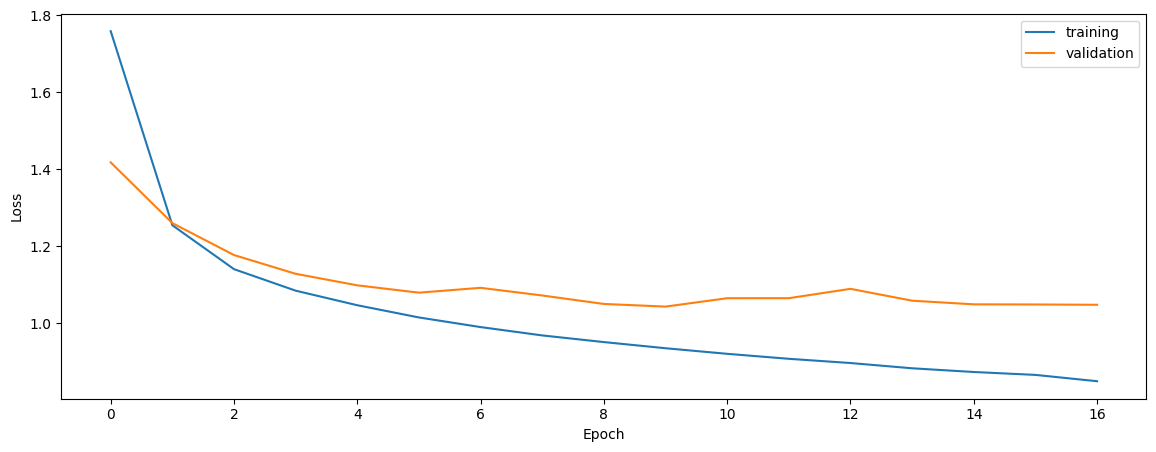

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.6305587118390213
0.5833657133975754
0.6327271843244032


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

normalized
0.6509281509016892
0.6345682369087892
0.6340546768260954


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.6462420938823557
0.6400542294728747
0.6407314257653579


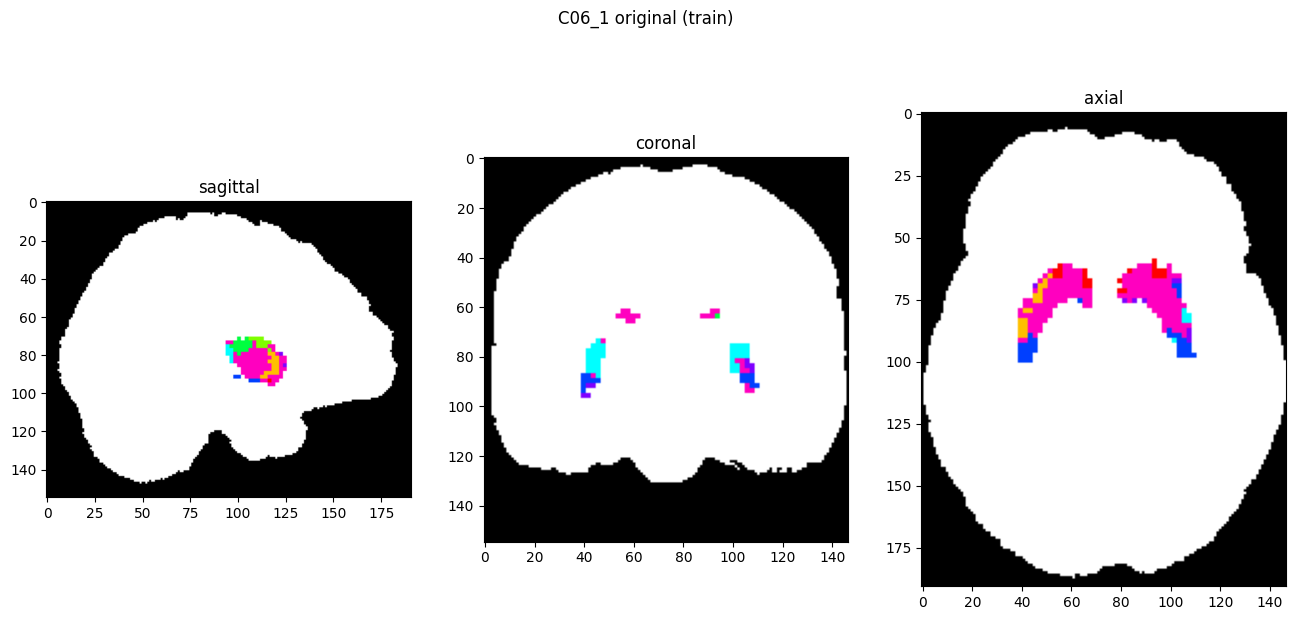

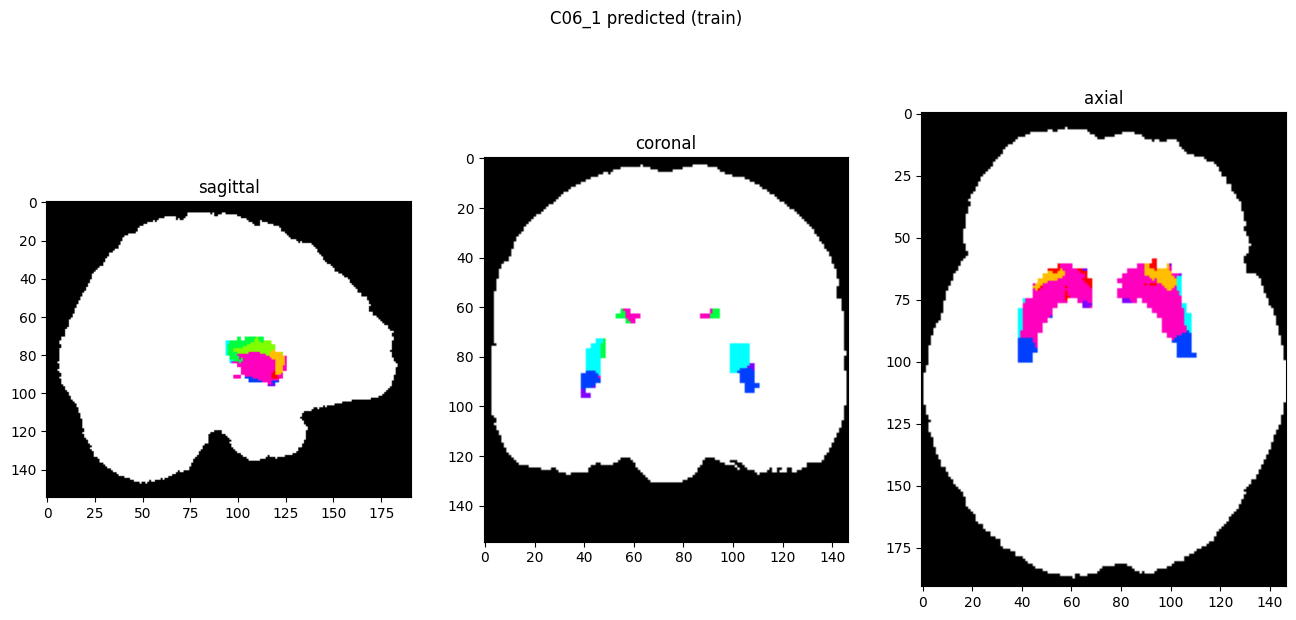

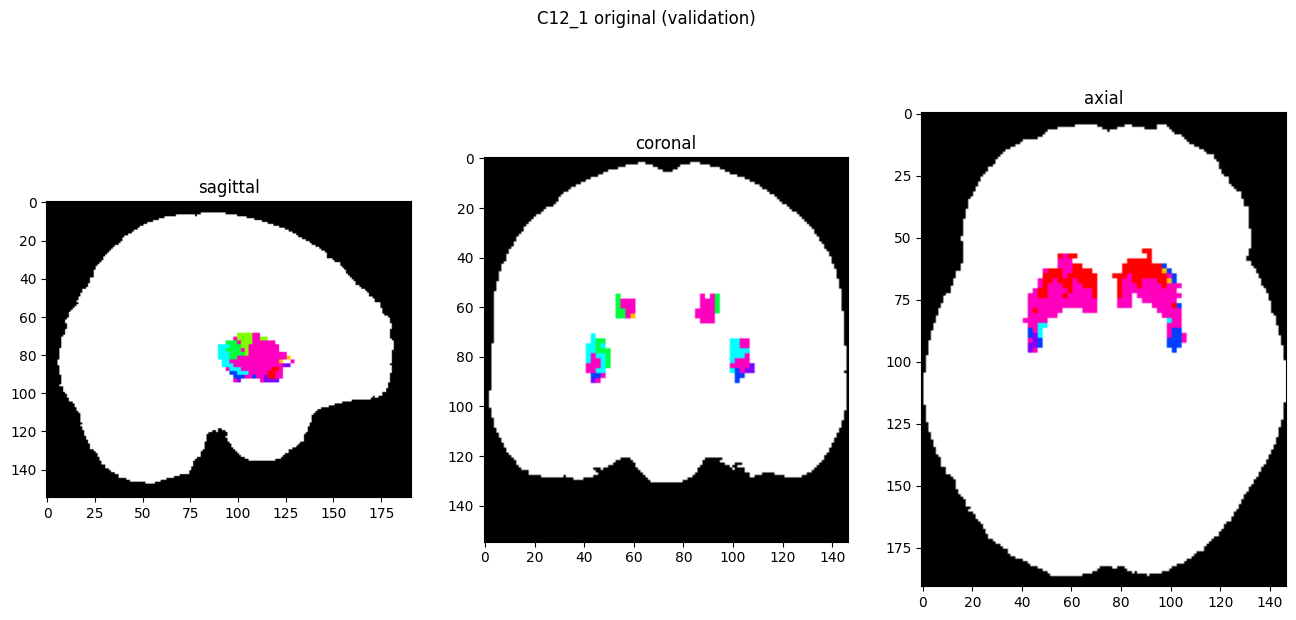

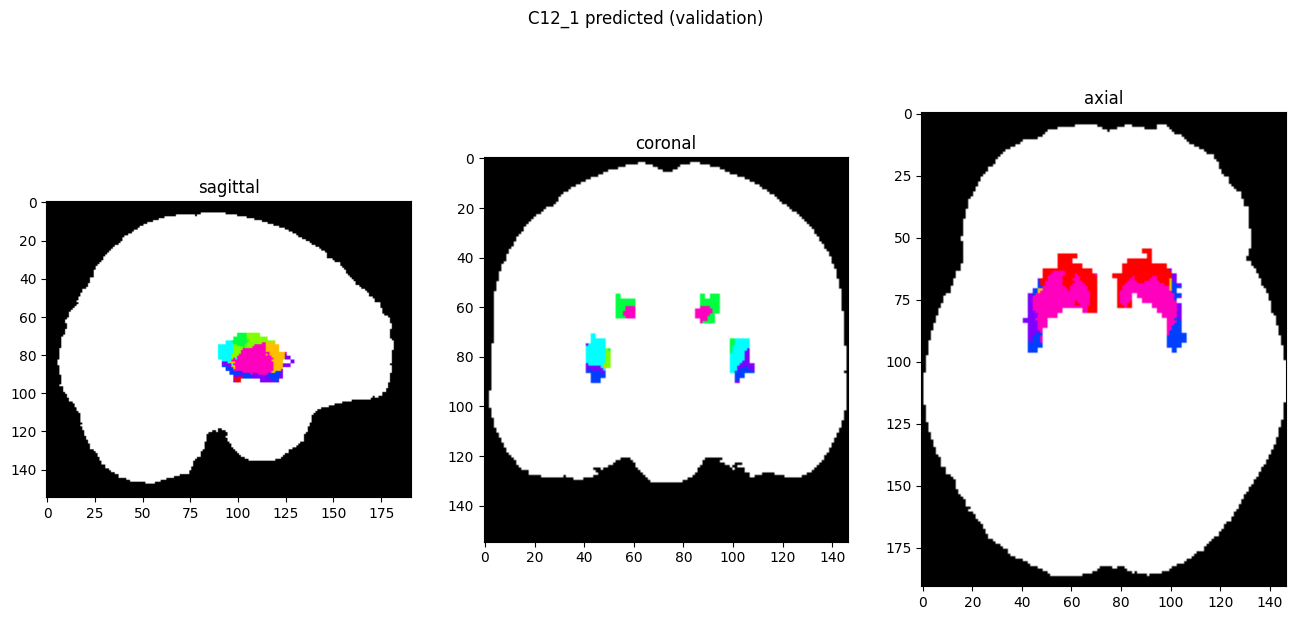

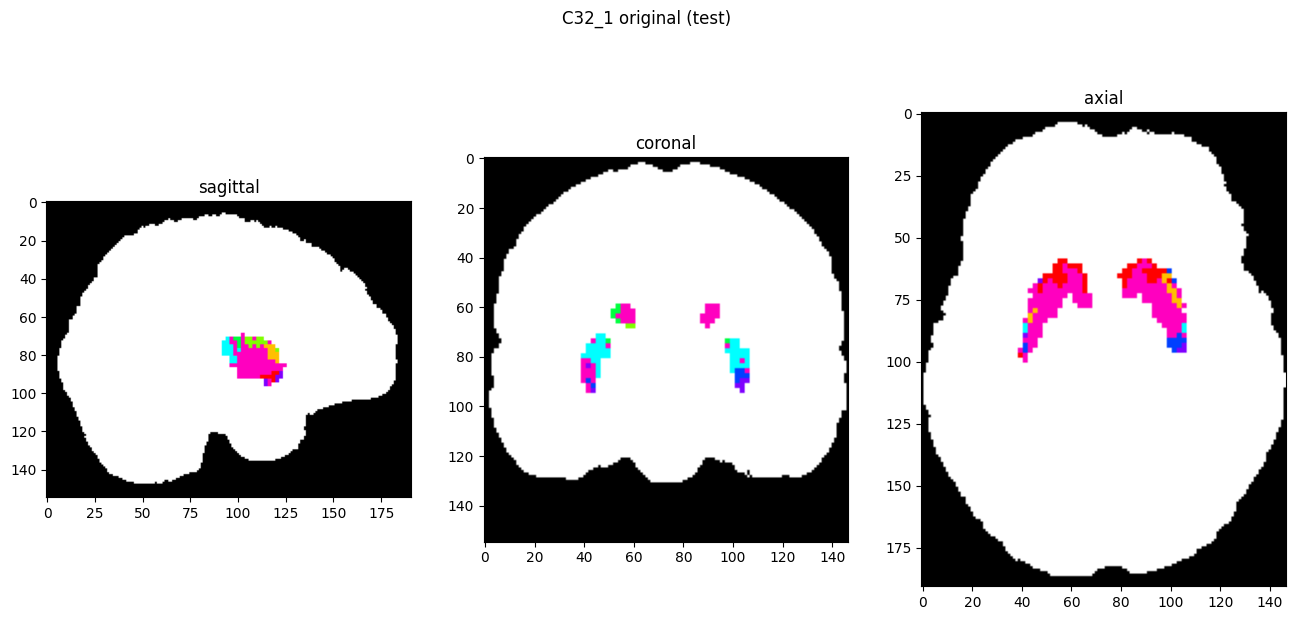

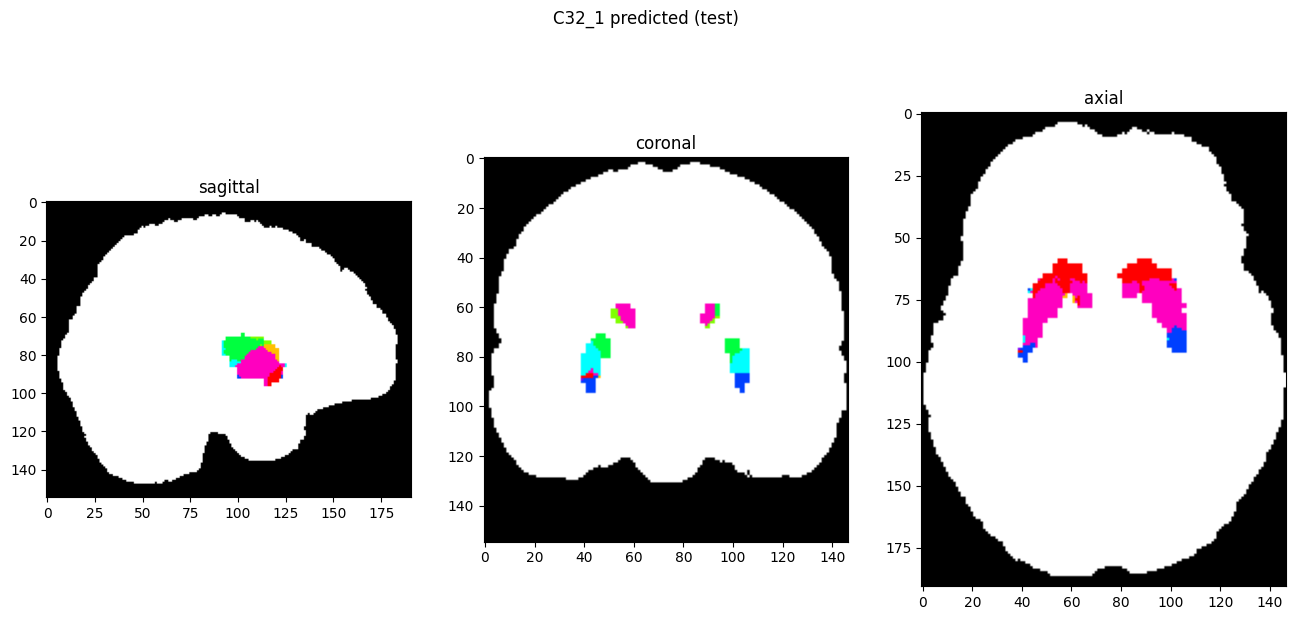

In [10]:
showResults(model, gen, threshold=0)